# Official Results for 'Discovering Foodborne Illness in Online Restaurant Reviews' in JAMIA, 2017

This notebook presents the official evaluation of classifiers presented in the paper.

Because of copyright restrictions, it is not possible to publish the data used in the experiments.

However, the final trained models may be found in the `best_models` directory for testing and further experimentation.

Additionally, those models are all retrained on the full training data within this notebook with a fixed random seed so that the final numbers could be reproduced if needed.

For inqueries about the results, models, or data, please contact [Tom Effland](mailto:teffland@cs.columbia.edu).

## Table of Contents

1. [Derivations of Selection Bias Corrections](#Selction-Bias-Correction)
2. [Data Ingestion](#)
3. [Defintions of Helper Functions](#)
4. 

# Selection Bias Correction

Let $T(x)$ be the biased selection process for labelling data at DOHMH. We treat it as a black-box and model it atomically.

Let $U$ be the set of all Yelp Reviews that have been processed by the system.

Let $B \subset U$ s.t. $B = \{(x,y) | T(x) = 1\}$. $B$ is the biased training set.

Let $B^c \subseteq U \setminus B = \{(x,y) | T(x) = 0\}$. $B^c$ is the nonbiased training set.


### Training: Error Rate

We can model the error rate of some classifier $f$ as:



and use plugin estimates:

$\hat{p}(T(x) = 1) = \frac{|B|}{|U|}$ (the % of labeled points)

$\hat{p}(f(x) \neq y | T(x)=1) = \frac{1}{|B|}\Sigma_{(x,y) \in B}{I[f(x) \neq y]}$

likewise,

$\hat{p}(f(x) \neq y | T(x)=0) = \frac{1}{|B^c|}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

therefore

$\hat{p}(f(x) \neq y) = w_B\Sigma_{(x,y) \in B}{I[f(x) \neq y]} + w_{B^c}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

where 

$w_B = \frac{1}{|U|}$ and $w_{B^c} = (1 - \frac{|B|}{|U|})(\frac{1}{|B^c|})$

Note that when $B^c$ is the entire complement of $B$, then $w_{B^c}$ reduces to $\frac{1}{|U|}$

So, if we are trying to minimize the classification error in the objective function then these are the sample weights to be used when calculating the error

### Testing: Area Under Precision-Recall Curve

We will evaluate models using the AUPR metric, calculated empirically on the dev and test sets.

This metric is appropriate because of the major positive-class imbalance in the dataset (estimated to be.7%).

The tricky thing is that our measures of precision and recall need to also be importance weighted, and the importance weights for precision will vary as we vary the threshold.

To see why, consider the probabilistic form of precision for some classifier $f$:

#### Precision

Let $U$ be the test set.

$Precision = p(y=1|f(x)=1) = \Sigma_{t}{p(y=1 | f(x)=1, T(x) = t)p(T(x)=t|f(x)=1)}$

Let $U_P \subset U$ be the set $\{(x,y) | f(x) = 1\}$. 

**Note** that $U_P$ varies with the classification threshold.

Then as with the error rate, we can find plugin estimates for the necessary quanities.

$\hat{p}(T(x) = 1|f(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B}{I[f(x)=1]} = \frac{|B \cap U_P|}{|U_P|}$

and so $\hat{p}(T(x) = 0|f(x)=1) = 1 - \frac{|B \cap U_P|}{|U_P|}$

Also,

$\hat{p}(y=1|f(x)=1, T(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
 $

and $\hat{p}(y=1|f(x)=1, T(x)=0) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

Therefore

$Precision = \frac{|B \cap U_P|}{|U_P|} \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
+ (1 - \frac{|B \cap U_P|}{|U_P|})\frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

#### Recall

The derivation for improtance-weighted (IW) recall follows similary to IW precision.

$Recall = p(f(x)=1|y=1) = \Sigma_{t}{p(f(x)=1| y=1, T(x) = t)p(T(x)=t|y=1)}$

Let $U_R \subset U$ be the set $\{(x,y) | y = 1\}$. 

**Note** that $U_R$ **does not** vary with the classification threshold.

The plugin estimates are:

$\hat{p}(T(x) = 1|y=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B}{I[y=1]} = \frac{|B \cap U_R|}{|U_R|}$

and so $\hat{p}(T(x) = 0|y=1) = 1 - \frac{|B \cap U_R|}{|U_R|}$

Also,

$\hat{p}(f(x)=1 |y=1, T(x)=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}$

and $\hat{p}(f(x)=1|y=1, T(x)=0) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

plugging in we have

$ Recall =  \frac{|B \cap U_R|}{|U_R|} \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}
+ (1 - \frac{|B \cap U_R|}{|U_R|}) \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

#### AUPR Curve

Finally, using the above plugin estimates, we can balance data from both $B$ and (a sample from) $B^c$.  We can obtain a series of ordered Precision-Recall points $E = \{(p,r,t)_i | r_i \leq r_{i'}\}$ by varying the classification threshold $t \in [0,1]$ and then using trapezoidal integration to approximate the area under the Recall vs. Precision curve.

#### Bootstrap

For the final evaluation, we would like confidence intervals about the AUPR. We find these by using the percentile bootstrap:

We calculate bootstrap statistics for the IW-AUPR as follows:

First we calculate the test data IW-AUPR. Call this $\bar{x}$.

Then we resample the test dataset with replacement $B$ times and obtain the IW-AUPR estimates for each set.

Call these $x_1, ...,  x_B$.

Then we can compute confidence intervals around $\bar{x}$ the usual way by finding the $\alpha=.025$ boundary quantiles $\delta_{\alpha}, \delta_{1-\alpha}$, such that 

$$P(\bar{x}^* - \delta_{1-\alpha} \leq \bar{x} \leq \bar{x}^* - \delta_{\alpha}) = .95$$

## Official Test Results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import itertools
from pprint import pprint

import numpy as np
import numpy.random as npr
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

In [3]:
from experiments.baseline_experiment_util import calc_train_importance_weights
from experiments.baseline_experiment_util import importance_weighted_precision_recall, importance_weighted_pr_curve
from experiments.baseline_experiment_util import setup_baseline_data, area_under_pr_curve
from sklearn.metrics import confusion_matrix

In [4]:
from experiments.lr_model import model as lr_model
from experiments.rf_model import model as rf_model
from experiments.svm_model import model as svm_model
from sklearn.externals import joblib

In [5]:
biased_data = setup_baseline_data(data_path='data', train_regime='biased', test_regime='gold', random_seed=0)
gold_data = setup_baseline_data(data_path='data', train_regime='gold', test_regime='gold', random_seed=0)
silver_data = setup_baseline_data(data_path='data', train_regime='silver', test_regime='gold', random_seed=0)

experiments/baseline_experiment_util.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  old_biased['is_foodborne'] = old_biased['is_foodborne'].map({'Yes':1, 'No':0})
experiments/baseline_experiment_util.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_biased['is_foodborne'] = new_biased['is_foodborne'].map({'Yes':1, 'No':0})
experiments/baseline_experiment_util.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [6]:
# train setup
biased_text = np.array(biased_data['train_data']['text'])
biased_sick = np.array(biased_data['train_data']['is_foodborne'])
biased_mult = np.array(biased_data['train_data']['is_multiple'])
biased_weights = calc_train_importance_weights(biased_data['train_data']['is_biased'], biased_data['U'])

gold_text = np.array(gold_data['train_data']['text'])
gold_sick = np.array(gold_data['train_data']['is_foodborne'])
gold_mult = np.array(gold_data['train_data']['is_multiple'])
gold_weights = calc_train_importance_weights(gold_data['train_data']['is_biased'], gold_data['U'])

silver_text = np.array(silver_data['train_data']['text'])
silver_sick = np.array(silver_data['train_data']['is_foodborne'])
silver_mult = np.array(silver_data['train_data']['is_multiple'])
silver_weights = calc_train_importance_weights(silver_data['train_data']['is_biased'], silver_data['U'])

# test setup
test_data = gold_data['test_data']
B = 10 # number of bootstrap test set resamples
random_seed = 0
all_results = {}

In [7]:
print silver_data['U']

1189569


In [8]:
def f1(precision, recall):
    return 2.*precision*recall/(precision+recall+1e-15)

def ci(xbar, samples, confidence_level=.95):
    diffs = [ xbar - xi for xi in samples]
    alpha = (1. - confidence_level)/2.
    ci_bottom = xbar - np.percentile(diffs, 100.*(1-alpha))
    ci_top = xbar - np.percentile(diffs, 100.*alpha)
    return ci_bottom, ci_top

def iw_bootstrap_score_ci(trues, preds, is_biased, scoring_func, 
                          B=1000, confidence_level=.95, 
                          random_seed=None,
                          **scoring_func_kwds):
    """ Compute a bootstrapped estimate of the importance weighted model score and stratified resampling.
    
    An intuitive and practical guide to bootstrap estimation:
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    """
    if random_seed: npr.seed(random_seed)
    xbar = scoring_func(trues, preds, is_biased, **scoring_func_kwds)
    samples = []
    biased_idxs = np.argwhere(is_biased).ravel()
    nonbiased_idxs = np.argwhere(~is_biased).ravel()
    print
    for i in range(B):
        print '\rB: {}/{}'.format(i,B),
        if len(nonbiased_idxs):
            sample = np.hstack([npr.choice(biased_idxs, len(biased_idxs)), 
                                npr.choice(nonbiased_idxs, len(nonbiased_idxs))])
        else:
            sample = npr.choice(biased_idxs, len(biased_idxs))
        samples.append(scoring_func(trues[sample], preds[sample], is_biased[sample], **scoring_func_kwds))
    ci_bottom, ci_top = ci(xbar, samples, confidence_level)
    return xbar, ci_bottom, ci_top, samples

def bootstrap_f1_ci(trues, preds, is_biased, random_seed=None, **bootstrap_kwds):
    def scorer(trues, preds, is_biased):
        p, r = importance_weighted_precision_recall(trues, preds, is_biased, threshold=.5)
        return f1(p,r)
    return iw_bootstrap_score_ci(trues, preds, is_biased, scorer,
                              random_seed=random_seed,
                              **bootstrap_kwds)

def bootstrap_aupr_ci(trues, preds, is_biased, random_seed=None, **bootstrap_kwds):
    def scorer(trues, preds, is_biased):
        ps, rs, ts = importance_weighted_pr_curve(trues, preds, is_biased, n_thresholds=50)
        return area_under_pr_curve(ps, rs)
    return iw_bootstrap_score_ci(trues, preds, is_biased, scorer,
                              random_seed=random_seed,
                              **bootstrap_kwds)

In [9]:
def subplot_confusion_matrix(cm, classes, 
                             fig, ax,
                             precision=None, recall=None, f1_ci=None,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Modified from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    xlabel = 'Predicted label'
    if (precision is not None) and (recall is not None):
        xlabel += '\nPrecision: {0:2.3f}, Recall: {1:2.3f}'.format(precision, recall)
    if f1_ci is not None:
        xlabel +='\nF1: {0:2.3f}, CI:({1:2.3f}, {2:2.3f})'.format(*f1_ci)
    ax.set_xlabel(xlabel)
    ax.grid(False)

def model_report(model, title, label_key, save_fname=None, test_data=test_data, **bootstrap_kwds):
    y_trues = np.array(test_data[label_key])
    is_biased = np.array(test_data['is_biased'])
    y_preds = model.predict(test_data['text'])
    y_pred_probs = model.predict_proba(test_data['text'])[:,1]
    ps, rs, ts = importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased)
    aupr, aupr_ci_bottom, aupr_ci_top, samples = bootstrap_aupr_ci(y_trues, y_pred_probs, is_biased, **bootstrap_kwds)
#     print '--- {} ---'.format(title)
#     print '  Precision@.5, Recall@.5: {0:2.2f}, {1:2.2f}'.format(precision, recall)
#     print '  AUPR: {0:2.2f}'.format(aupr)
    fig, axs = plt.subplots(2,2, figsize=(8,8))
    axs[0,0].plot(rs, ps, label='AUPR: {0:2.3f} CI=({1:2.3f}, {2:2.3f})'.format(aupr, aupr_ci_bottom, aupr_ci_top))
    axs[0,0].set_title('Precision Recall Curve')
    axs[0,0].set_xlabel('Recall')
    axs[0,0].set_ylabel('Precision')
    axs[0,0].legend(loc=8)
    
    # plot out cms for mixed, biased, and nonbiased
    precision_m, recall_m = importance_weighted_precision_recall(y_trues, y_pred_probs, is_biased, .5)
    f1_ci_m = bootstrap_f1_ci(y_trues, y_pred_probs, is_biased, **bootstrap_kwds)
    cm = confusion_matrix(y_trues, y_preds)
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[0,1], 
                             title='Mixed Bias',
                             precision=precision_m, recall=recall_m, f1_ci=f1_ci_m[:3])
    # biased
    precision_b, recall_b = importance_weighted_precision_recall(y_trues[is_biased], 
                                                             y_pred_probs[is_biased], 
                                                             is_biased[is_biased], .5)
    f1_ci_b = bootstrap_f1_ci(y_trues[is_biased], y_pred_probs[is_biased], is_biased[is_biased], **bootstrap_kwds)
    cm = confusion_matrix(y_trues[is_biased], y_preds[is_biased])
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[1,0], 
                             title='Biased',
                             precision=precision_b, recall=recall_b, f1_ci=f1_ci_b[:3])
    # nonbiased
    # there is no point to reporting precision, recall here since there are no positives
    # but we do it anyways in case the dataset were to change
    precision, recall = importance_weighted_precision_recall(y_trues[~is_biased], 
                                                             y_pred_probs[~is_biased], 
                                                             is_biased[~is_biased], .5)
#     f1_ci = bootstrap_f1_ci(y_trues[~is_biased], y_pred_probs[~is_biased], is_biased[~is_biased], **bootstrap_kwds)
    cm = confusion_matrix(y_trues[~is_biased], y_preds[~is_biased])
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[1,1], 
                             title="Nonbiased (all No's)",
                             precision=precision, recall=recall)
    
    
    
    fig.suptitle(title + ' Test Report', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    if save_fname:
        plt.savefig(save_fname+'_report.pdf')
    
    # also plot the bootstrap historgrams to make sure they look ok
    fig2, axs2 = plt.subplots(1,3, figsize=(12,4))
    axs2[0].hist(samples, bins=100)
    axs2[0].axvline(aupr, color='red')
    axs2[0].axvspan(aupr_ci_bottom, aupr_ci_top, alpha=.25, color='red')
    axs2[0].set_title('AUPR Bootstrap')
    axs2[1].hist(f1_ci_m[3], bins=100)
    axs2[1].axvline(f1_ci_m[0], color='red')
    axs2[1].axvspan(f1_ci_m[1], f1_ci_m[2], alpha=.25, color='red')
    axs2[1].set_title('Mixed Bias F1 Boostrap')
    axs2[2].hist(f1_ci_b[3], bins=100)
    axs2[2].axvline(f1_ci_b[0], color='red')
    axs2[2].axvspan(f1_ci_b[1], f1_ci_b[2], alpha=.25, color='red')
    axs2[2].set_title('Biased F1 Boostrap')
    fig2.suptitle(title + ' Bootstrap Histograms', fontsize=14)
    fig2.tight_layout()
    fig2.subplots_adjust(top=0.85)
    if save_fname:
        plt.savefig(save_fname+'_bootstrap_hists.pdf')
        
    return {
        'aupr':aupr,
        'aupr_ci':(aupr_ci_bottom, aupr_ci_top),
        'aupr_samples':samples,
        'mixed_precision':precision_m,
        'mixed_recall':recall_m,
        'mixed_f1':f1_ci_m[0],
        'mixed_f1_ci':f1_ci_m[1:3],
        'mixed_f1_samples':f1_ci_m[3],
        'biased_precision':precision_b,
        'biased_recall':recall_b,
        'biased_f1':f1_ci_b[0],
        'biased_f1_ci':f1_ci_b[1:3],
        'biased_f1_samples':f1_ci_b[3]
    }
        
def print_model_hyperparams(model, name):
    useful_params = {k:v for k,v in model.get_params().items() if '__' in k}
    print "*** {} Hyperparameters ***".format(name)
    pprint(useful_params)

In [10]:
def precision_at_recall(model, label_key, desired_recall, test_data=test_data):
    """
    Return the precision, recall, and threshold of a model that comes closest to the `desired_recall` value.
    Additionally, we return the error := true_recall - desired_recall.
    """
    y_trues = np.array(test_data[label_key])
    is_biased = np.array(test_data['is_biased'])
    y_preds = model.predict(test_data['text'])
    y_pred_probs = model.predict_proba(test_data['text'])[:,1]
    ps, rs, ts = importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased)
    closest = sorted(zip(ps, rs, ts), key=lambda x:abs(x[1]-desired_recall))[0]
    return closest + (closest[1]-desired_recall,)

def pr_curves(model_list, title_list, main_title, label_key, save_fname=None, test_data=test_data):
    y_trues = np.array(test_data[label_key])
    is_biased = np.array(test_data['is_biased'])
    
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    for model, title in zip(model_list, title_list):
        y_preds = model.predict(test_data['text'])
        y_pred_probs = model.predict_proba(test_data['text'])[:,1]
        ps, rs, ts = importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased)
        ax.plot(rs, ps, label='{}'.format(title))
    ax.set_title(main_title)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc=8)
    if save_fname:
        plt.savefig(save_fname+'_pr_curves.pdf')

## Sick Task

Here are the notable stats for testing on the Sick task:
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews are have `No` labels
* The 1975 biased reviews are about 52% `Yes`/`No` (1026/949)

In [11]:
print pd.Series(biased_sick).value_counts(dropna=False)
print 5899./len(biased_sick)

1    5899
0    5667
dtype: int64
0.510029396507


In [12]:
gold_mult[~np.array(gold_data['train_data']['is_biased'])].sum()

1

In [13]:
len(biased_sick), len(test_data['is_foodborne'])

(11566, 2975)

In [14]:
pd.Series(test_data['is_foodborne']).value_counts(dropna=False)

0    2026
1     949
dtype: int64

In [15]:
pd.Series(test_data['is_biased']).value_counts(dropna=False)

True     1975
False    1000
dtype: int64

### Logistic Regression

In [16]:
best_sick_lr_biased = joblib.load('experiments/best_models/best_lr_sick_biased.pkl')
best_sick_lr_gold = joblib.load('experiments/best_models/best_lr_sick_gold.pkl')
best_sick_lr_silver = joblib.load('experiments/best_models/best_lr_sick_silver.pkl')

/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator P

In [17]:
best_sick_lr_biased.fit(biased_text, biased_sick, logreg__sample_weight=biased_weights)
best_sick_lr_gold.fit(gold_text, gold_sick, logreg__sample_weight=gold_weights)
best_sick_lr_silver.fit(silver_text, silver_sick, logreg__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.92876195959267271, max_features=None,
        min_df=1, ngram_range=(1, 3), preprocessor=None, stop_words...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


B: 9/10         
B: 9/10 
B: 9/10  12 seconds


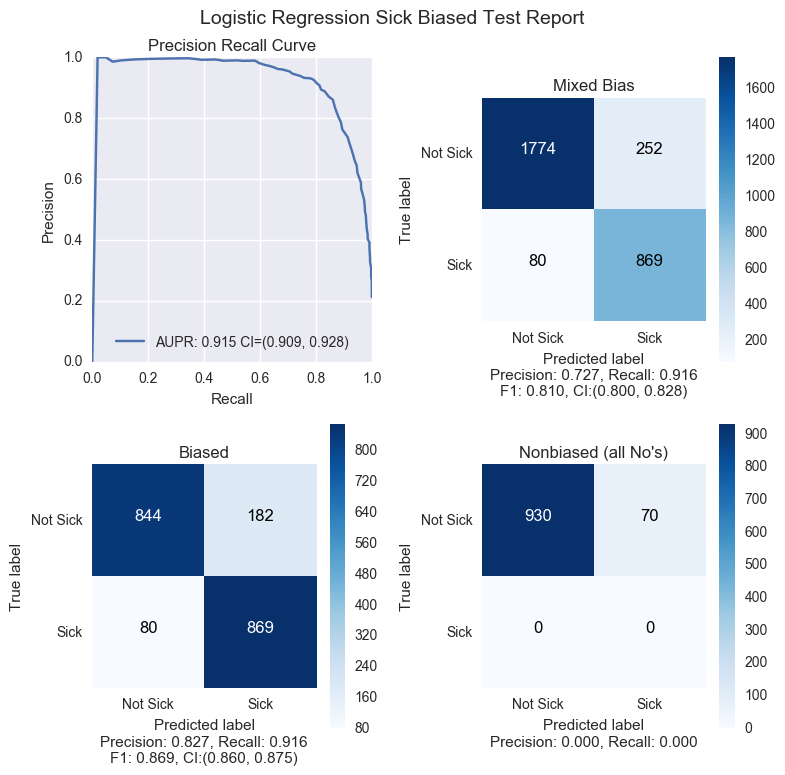

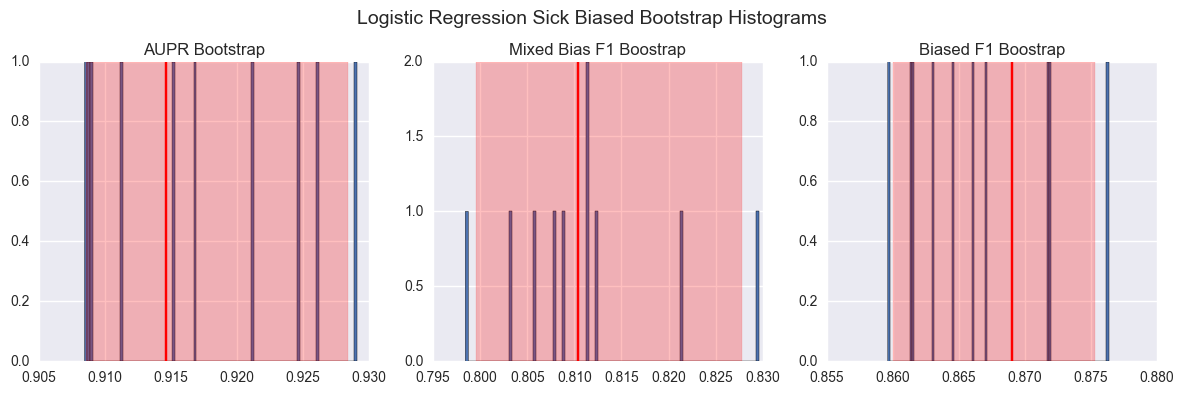

In [18]:
start = time.time()
title = 'Logistic Regression Sick Biased'
all_results[title] = model_report(best_sick_lr_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_lr_biased',
                                  B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 9/10         
B: 9/10 
B: 9/10   12 seconds


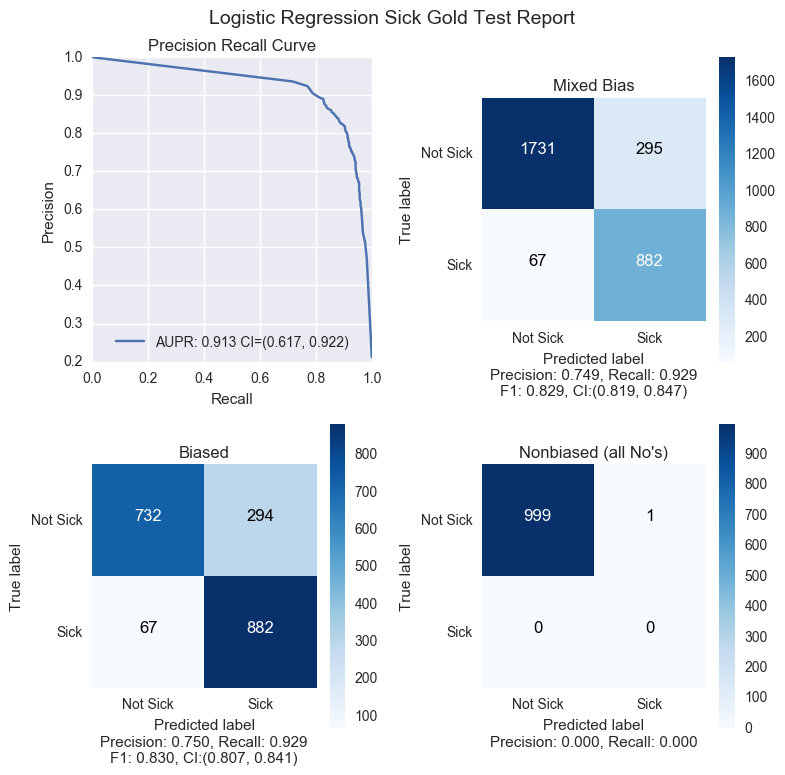

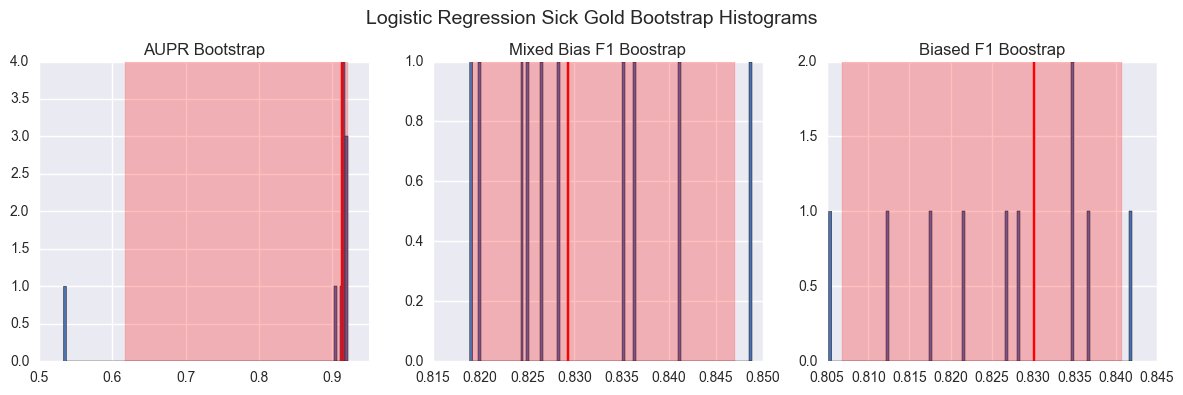

In [19]:
start = time.time()
title = 'Logistic Regression Sick Gold'
all_results[title] = model_report(best_sick_lr_gold, title, 'is_foodborne', 
                                   save_fname='figures/sick_lr_gold',
                                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 9/10         
B: 9/10 
B: 9/10  11 seconds


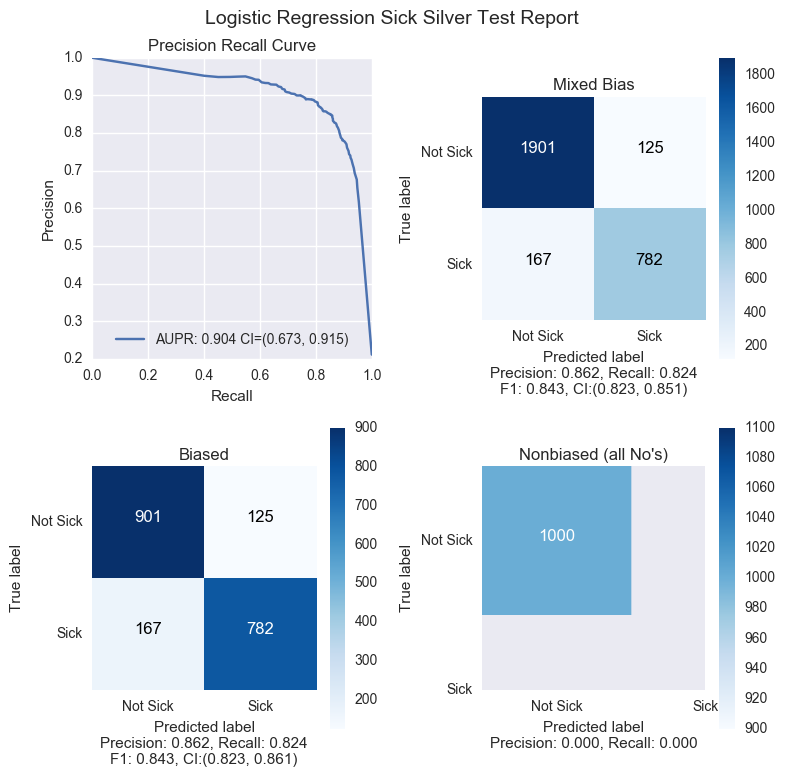

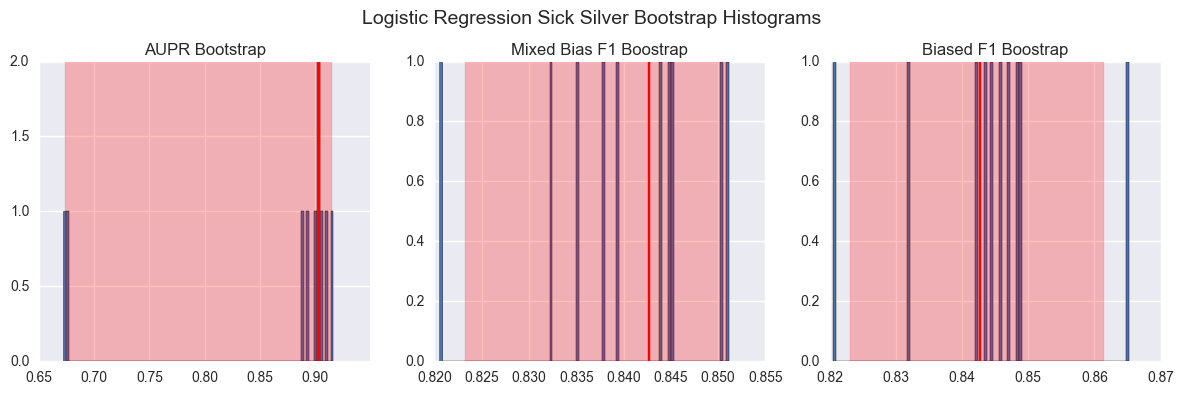

In [20]:
start = time.time()
title = 'Logistic Regression Sick Silver'
all_results[title] = model_report(best_sick_lr_silver, title, 'is_foodborne', 
                       save_fname='figures/sick_lr_silver',
                       B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

The Silver classifier is high-precision, but we are interested in its precision a high recall.
Since the original system had a recall of .96, we see what its precision at this recall is

In [22]:
result = precision_at_recall(best_sick_lr_biased, 'is_foodborne', .95)
print 'Biased Precision:{0:0.2f}, Recall:{1:0.2f}, Threshold:{2:0.2f}, Error:{3:0.2f}'.format(*result)

result = precision_at_recall(best_sick_lr_gold, 'is_foodborne', .95)
print 'Gold Precision:{0:0.2f}, Recall:{1:0.2f}, Threshold:{2:0.2f}, Error:{3:0.2f}'.format(*result)

result = precision_at_recall(best_sick_lr_silver, 'is_foodborne', .95)
print 'Silver Precision:{0:0.2f}, Recall:{1:0.2f}, Threshold:{2:0.2f}, Error:{3:0.2f}'.format(*result)

Precision:0.62, Recall:0.95, Threshold:0.44, Error:-0.00
Precision:0.68, Recall:0.95, Threshold:0.24, Error:0.00
Precision:0.65, Recall:0.95, Threshold:0.02, Error:-0.00


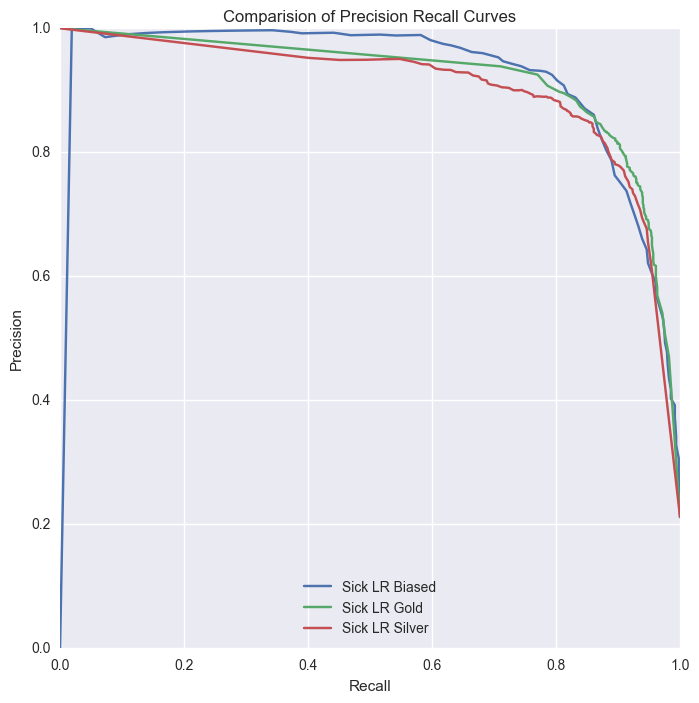

In [29]:
pr_curves([best_sick_lr_biased, best_sick_lr_gold, best_sick_lr_silver], 
          ['Sick LR Biased', 'Sick LR Gold', 'Sick LR Silver'], 
          'Comparision of Precision Recall Curves', 'is_foodborne', save_fname='sick_lr')

In [52]:
def precision_derivative_curves(model_list, title_list, main_title, label_key, save_fname=None, test_data=test_data):
    """ 
    Sometimes PR-curves don't help much in estimating the loss in precision 
    per unit gain of recall via inspection.
    
    Instead it can be instructive to estimate the derivative of the pr-curve and then plot that curve.
    
    Using the empirical pr-curve, we use a centered finite difference with a truncation error of $O(h^4)$ 
    to estimate the derivative of the precision over recall curve.
    """
    finite_difference = lambda h, f_2, f_1, f1, f2: (-f2 + 8*f1 - 8*f_1 + f_2) / float(12*h)
    y_trues = np.array(test_data[label_key])
    is_biased = np.array(test_data['is_biased'])
    
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    for k, (model, title) in enumerate(zip(model_list, title_list)):
        y_preds = model.predict(test_data['text'])
        y_pred_probs = model.predict_proba(test_data['text'])[:,1]
        ps, rs, ts = importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased)
        precision_rates = []
        for i in range(2, len(ps)-2):
            precision_rates.append(finite_difference(.01, ps[i-2], ps[i-1], ps[i+1], ps[i+2]))
        ax.plot(rs[50:-2], precision_rates[48:], label='{}'.format(title), dashes=[(k+1)*3, k+2])
    ax.set_title(main_title)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='best')
    if save_fname:
        plt.savefig(save_fname+'_precision_rate_curves.pdf')

$\frac{\partial Precision}{\partial Recall}$

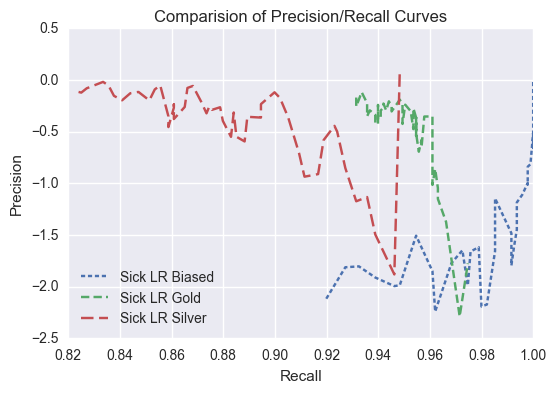

In [54]:
precision_derivative_curves([best_sick_lr_biased, best_sick_lr_gold, best_sick_lr_silver], 
          ['Sick LR Biased', 'Sick LR Gold', 'Sick LR Silver'], 
          'Comparision of Precision/Recall Curves', 'is_foodborne', save_fname='sick_lr')

In [16]:
print_model_hyperparams(best_sick_lr_biased, 'Logistic Regression Sick Biased')
print
print_model_hyperparams(best_sick_lr_gold, 'Logistic Regression Sick Gold')
print
print_model_hyperparams(best_sick_lr_silver, 'Logistic Regression Sick Silver')
print

*** Logistic Regression Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.84528542746895707,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 1.0043849350273031,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': 'l2

### Random Forest

In [17]:
best_sick_rf_biased = joblib.load('experiments/best_models/best_rf_sick_biased.pkl')
best_sick_rf_gold = joblib.load('experiments/best_models/best_rf_sick_gold.pkl')
best_sick_rf_silver = joblib.load('experiments/best_models/best_rf_sick_silver.pkl')

/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Ran

In [18]:
best_sick_rf_biased.fit(biased_text, biased_sick, rf__sample_weight=biased_weights)
best_sick_rf_gold.fit(gold_text, gold_sick, rf__sample_weight=gold_weights)
best_sick_rf_silver.fit(silver_text, silver_sick, rf__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.79926139280934727, max_features=1000,
        min_df=1, ngram_range=(1, 3), preprocessor=None, stop_words...estimators=134, n_jobs=4, oob_score=True, random_state=0,
            verbose=0, warm_start=False))])


B: 999/1000
B: 999/1000
B: 999/1000 540 seconds


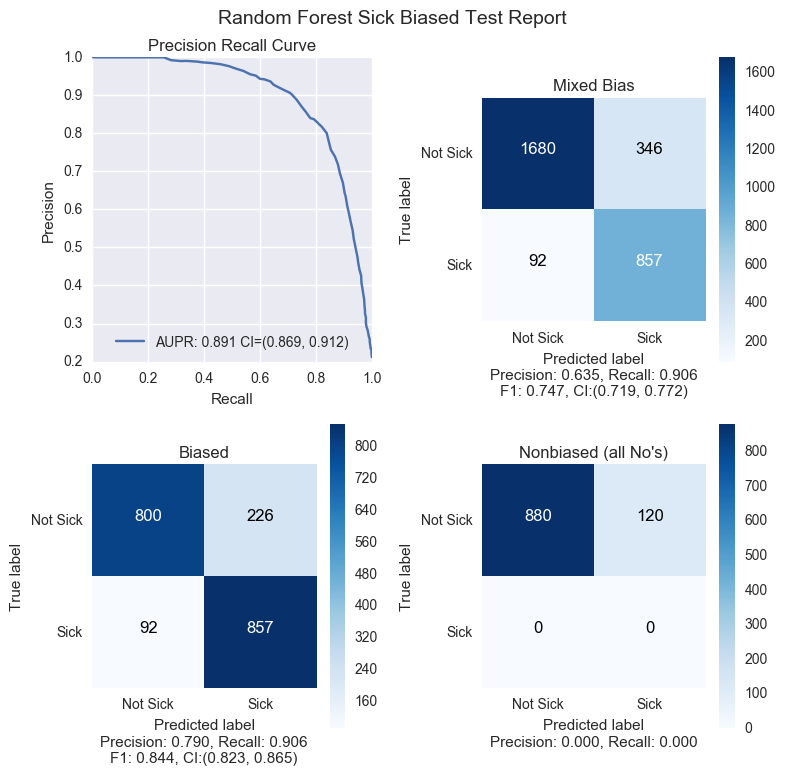

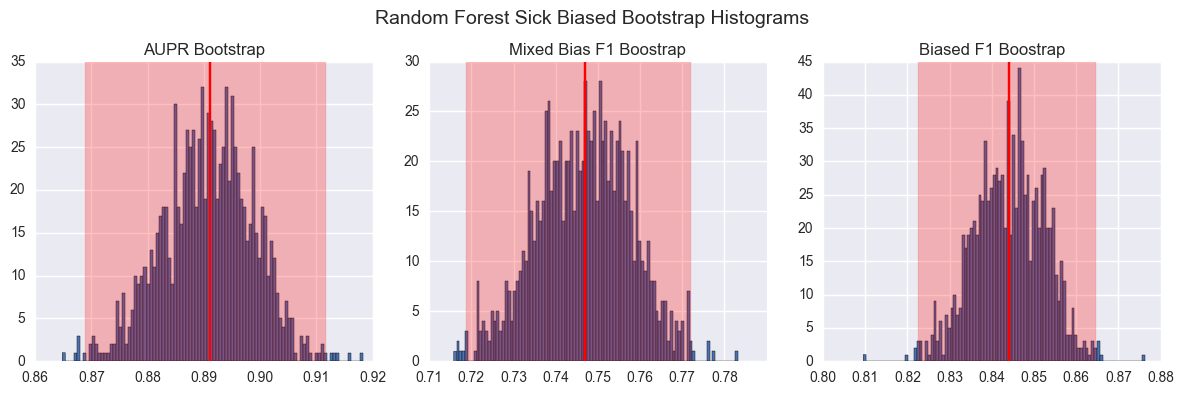

In [54]:
start = time.time()
title = 'Random Forest Sick Biased'
all_results[title] = model_report(best_sick_rf_biased, title, 'is_foodborne',
                                   save_fname='figures/sick_rf_biased',
                                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 633 seconds


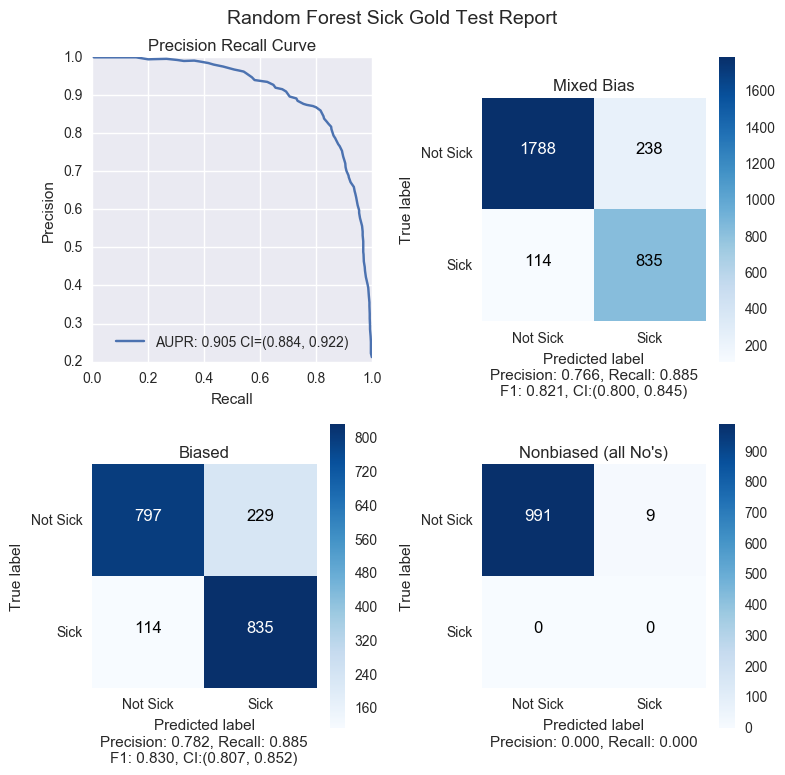

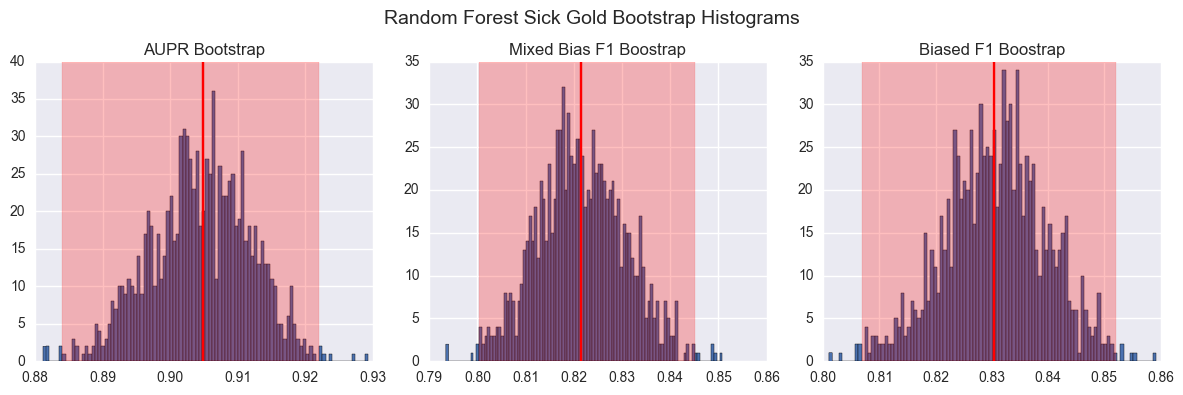

In [55]:
start = time.time()
title = 'Random Forest Sick Gold'
all_results[title] = model_report(best_sick_rf_gold, title, 'is_foodborne',
                                   save_fname='figures/sick_rf_gold',
                                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 632 seconds


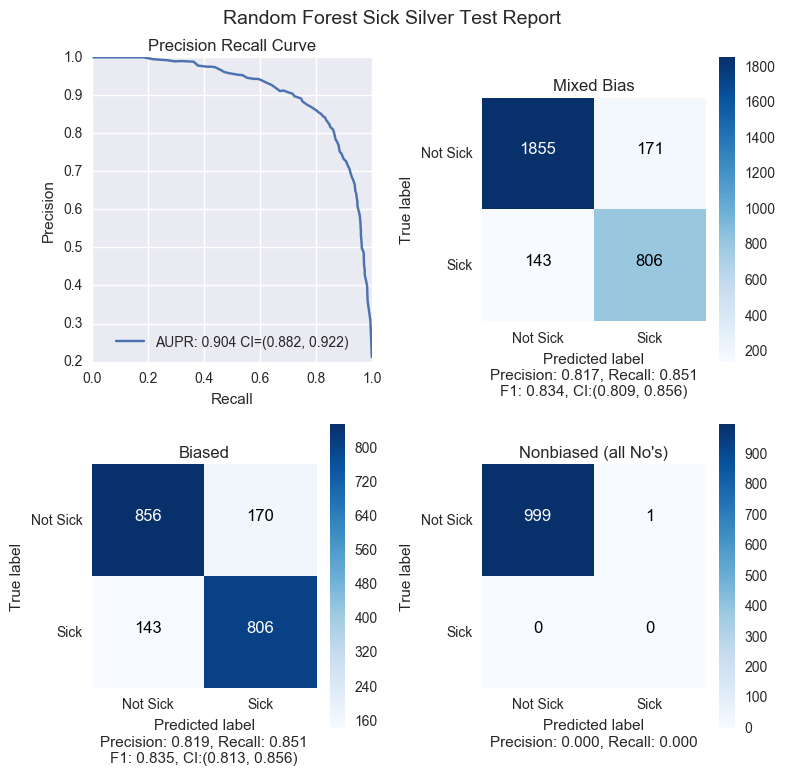

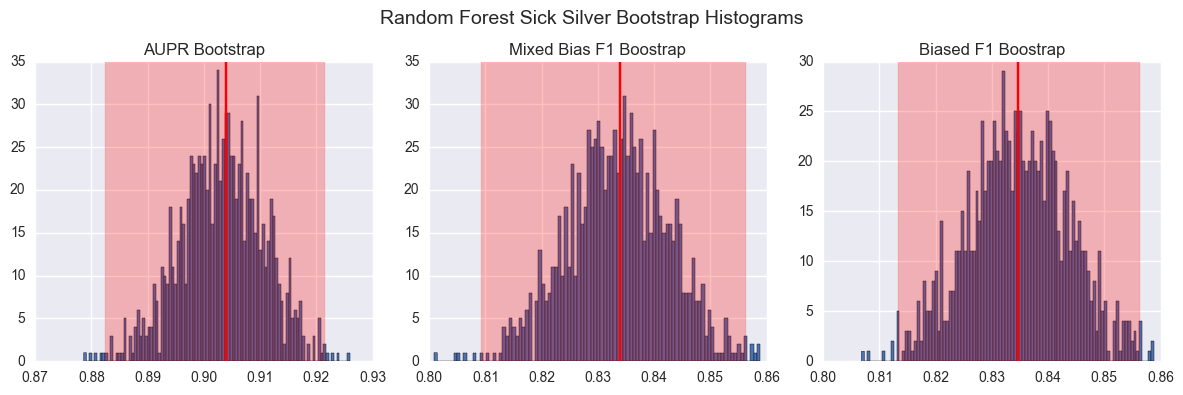

In [56]:
start = time.time()
title = 'Random Forest Sick Silver'
all_results[title] = model_report(best_sick_rf_silver, title, 'is_foodborne',
                   save_fname='figures/sick_rf_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [22]:
print_model_hyperparams(best_sick_rf_biased, 'Random Forest Sick Biased')
print
print_model_hyperparams(best_sick_rf_gold, 'Random Forest Sick Gold')
print
print_model_hyperparams(best_sick_rf_silver, 'Random Forest Sick Silver')
print

*** Random Forest Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.86314175655936753,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 192,
 'rf__n_jobs': 4,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### SVM

In [23]:
best_sick_svm_biased = joblib.load('experiments/best_models/best_svm_sick_biased.pkl')
best_sick_svm_gold = joblib.load('experiments/best_models/best_svm_sick_gold.pkl')
best_sick_svm_silver = joblib.load('experiments/best_models/best_svm_sick_silver.pkl')

In [24]:
best_sick_svm_biased.fit(biased_text, biased_sick, svc__sample_weight=biased_weights)
best_sick_svm_gold.fit(gold_text, gold_sick, svc__sample_weight=gold_weights)
best_sick_svm_silver.fit(silver_text, silver_sick, svc__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.86862870075359322, max_features=None,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


B: 999/1000
B: 999/1000
B: 999/1000 608 seconds


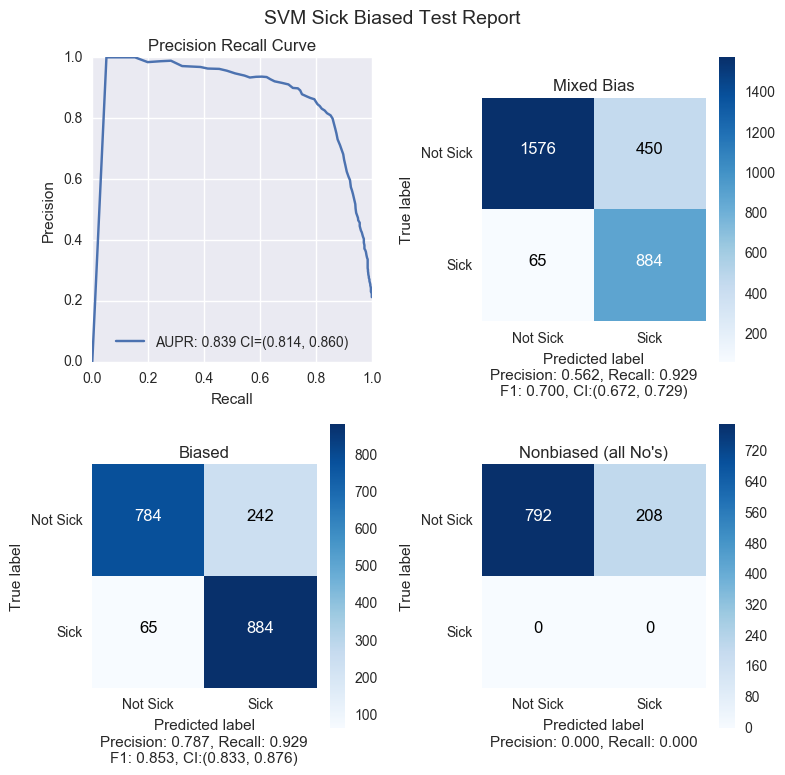

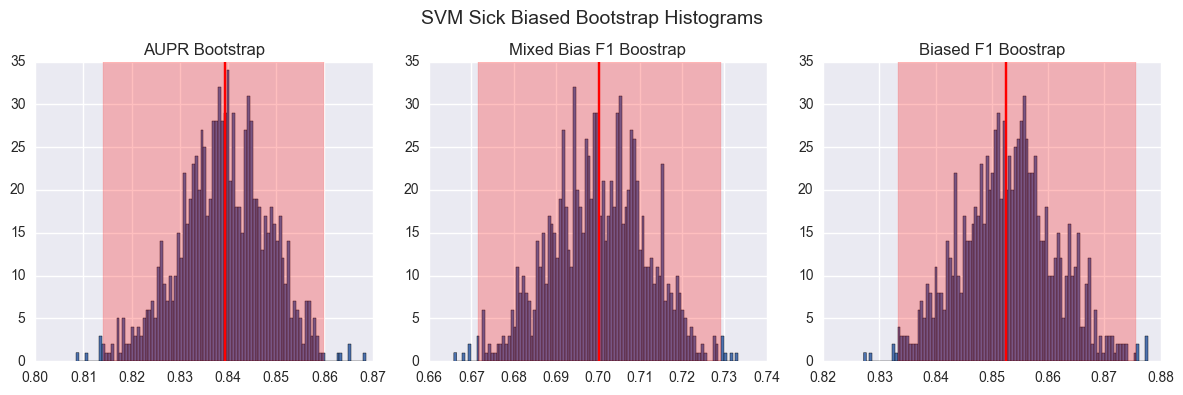

In [57]:
start = time.time()
title = 'SVM Sick Biased'
all_results[title] = model_report(best_sick_svm_biased, title, 'is_foodborne',
                   save_fname='figures/sick_svm_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 599 seconds


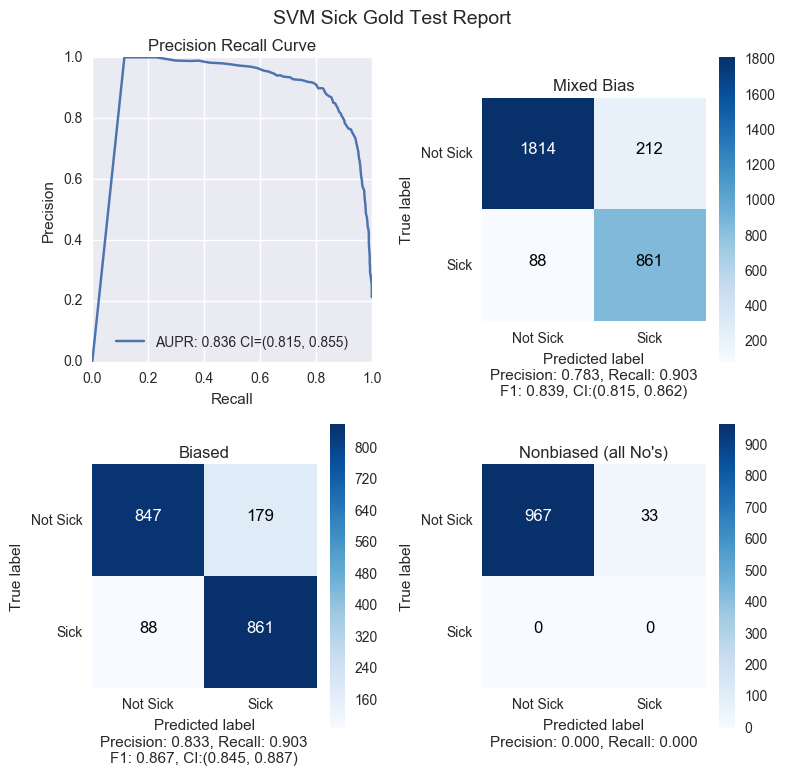

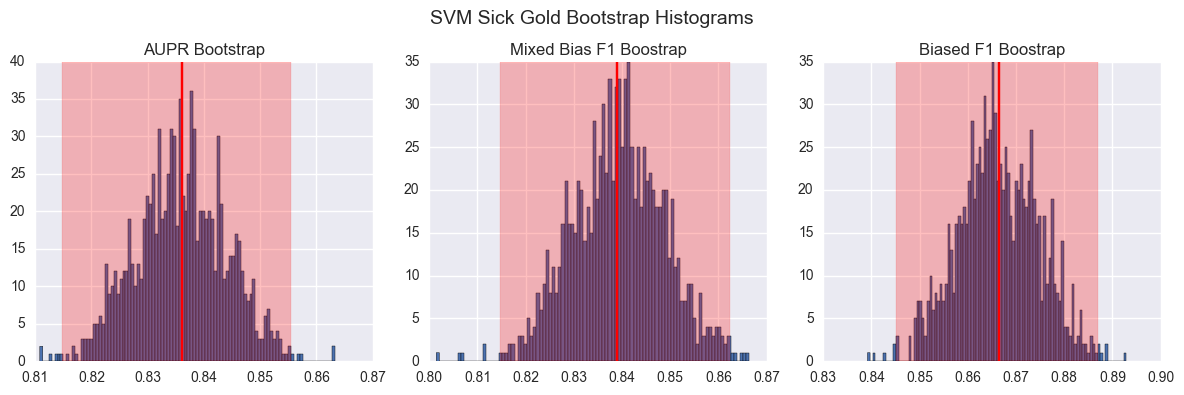

In [58]:
start = time.time()
title = 'SVM Sick Gold'
all_results[title] = model_report(best_sick_svm_gold, title, 'is_foodborne',
                   save_fname='figures/sick_svm_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 571 seconds


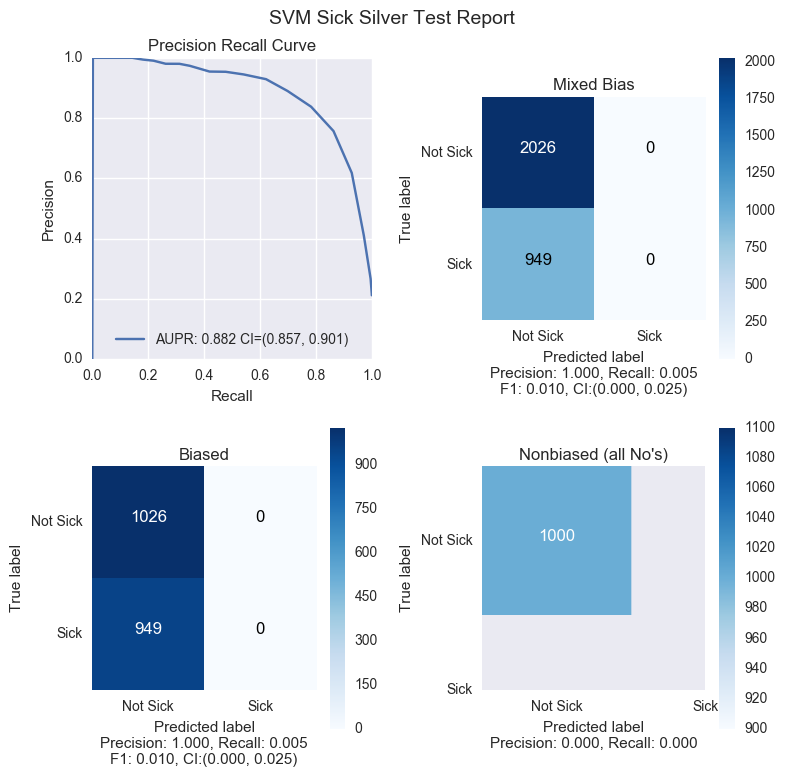

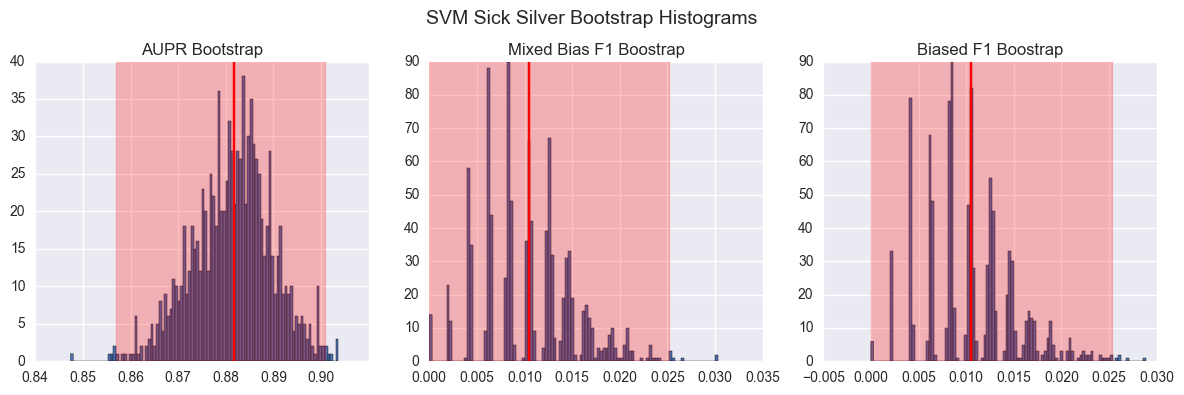

In [59]:
start = time.time()
title = 'SVM Sick Silver'
all_results[title] = model_report(best_sick_svm_silver, title, 'is_foodborne',
                   save_fname='figures/sick_svm_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [28]:
print_model_hyperparams(best_sick_svm_biased, 'SVM Sick Biased')
print
print_model_hyperparams(best_sick_svm_gold, 'SVM Sick Gold')
print
print_model_hyperparams(best_sick_svm_silver, 'SVM Sick Silver')
print

*** SVM Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.81119879980332688,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 1.0712799833880016,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'linear',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': None,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': Fal

## Multiple Task

Here are the notable stats for testing on the Multple task:
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews all have `No` labels
* The 1975 biased reviews are about 14% `Yes` (277 `Yes`, 1698 `No`)

In [29]:
pd.Series(test_data['is_multiple']).value_counts(dropna=False)

0    2698
1     277
dtype: int64

### Logistic Regression

In [30]:
best_mult_lr_biased = joblib.load('experiments/best_models/best_lr_mult_biased.pkl')
best_mult_lr_gold = joblib.load('experiments/best_models/best_lr_mult_gold.pkl')
best_mult_lr_silver = joblib.load('experiments/best_models/best_lr_mult_silver.pkl')

In [32]:
best_mult_lr_biased.fit(biased_text, biased_mult, logreg__sample_weight=biased_weights)
best_mult_lr_gold.fit(gold_text, gold_mult, logreg__sample_weight=gold_weights)
best_mult_lr_silver.fit(silver_text, silver_mult, logreg__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.8181949574949251, max_features=None,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words=...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


B: 999/1000
B: 999/1000
B: 999/1000 572 seconds


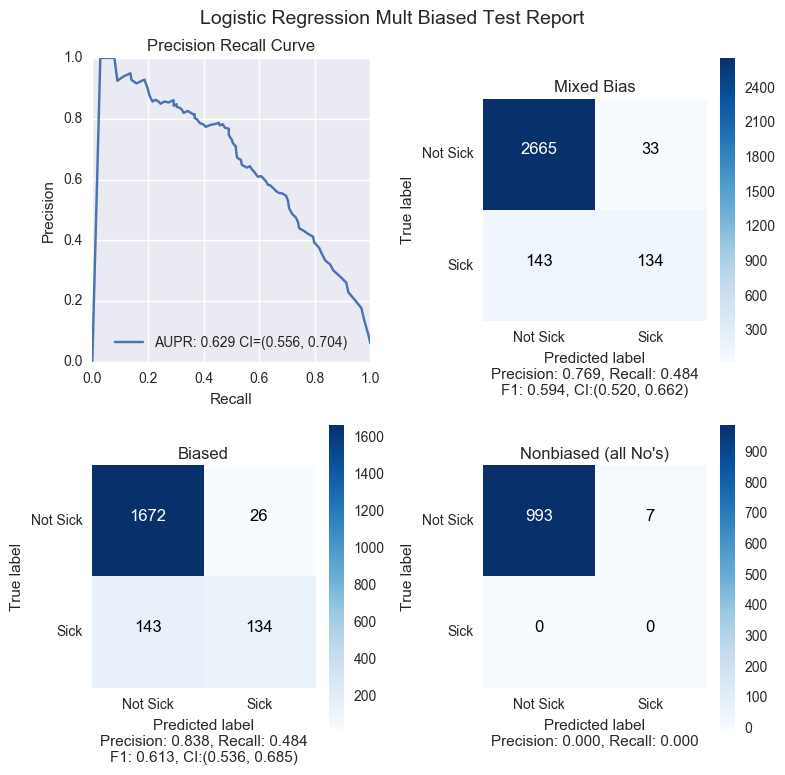

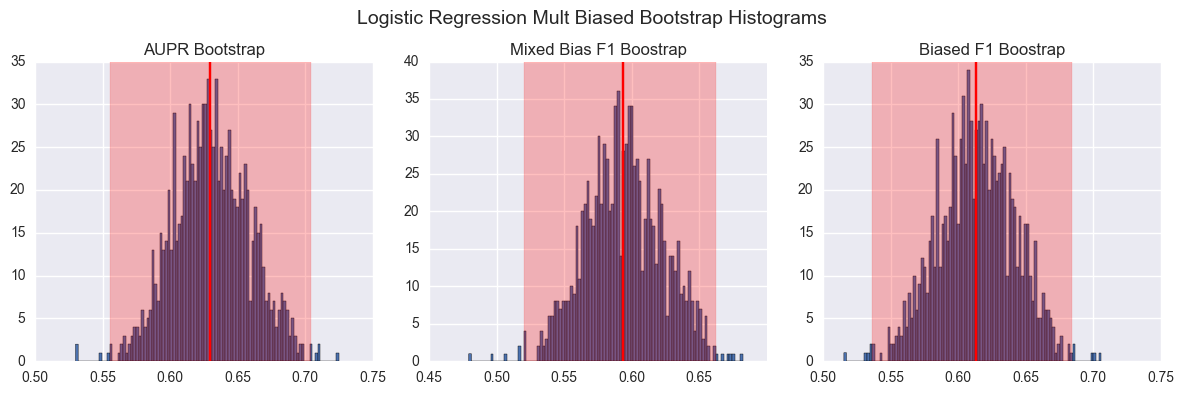

In [60]:
start = time.time()
title = 'Logistic Regression Mult Biased'
all_results[title] = model_report(best_mult_lr_biased, title, 'is_multiple',
                   save_fname='figures/mult_lr_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 544 seconds


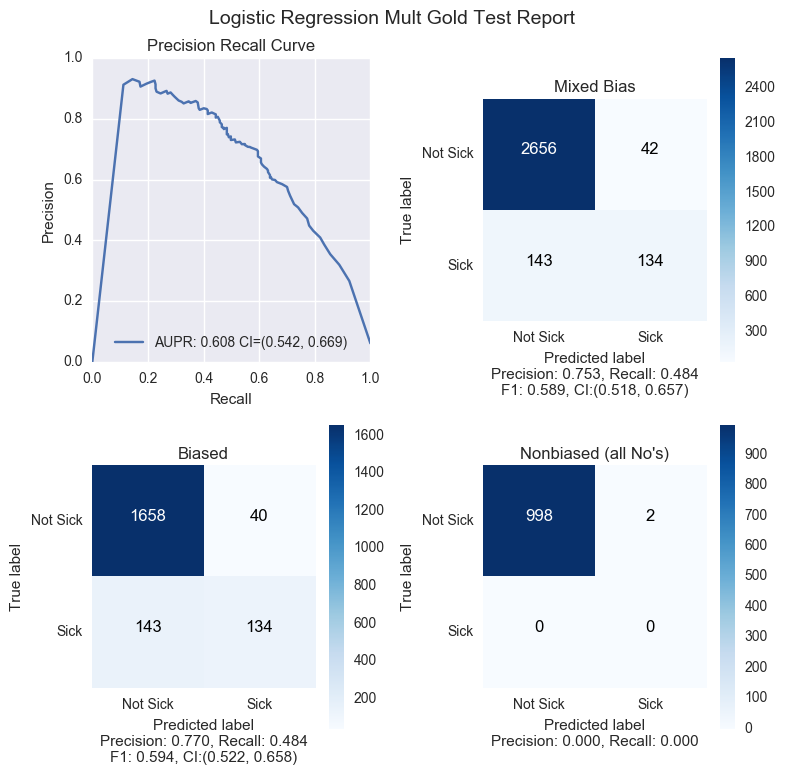

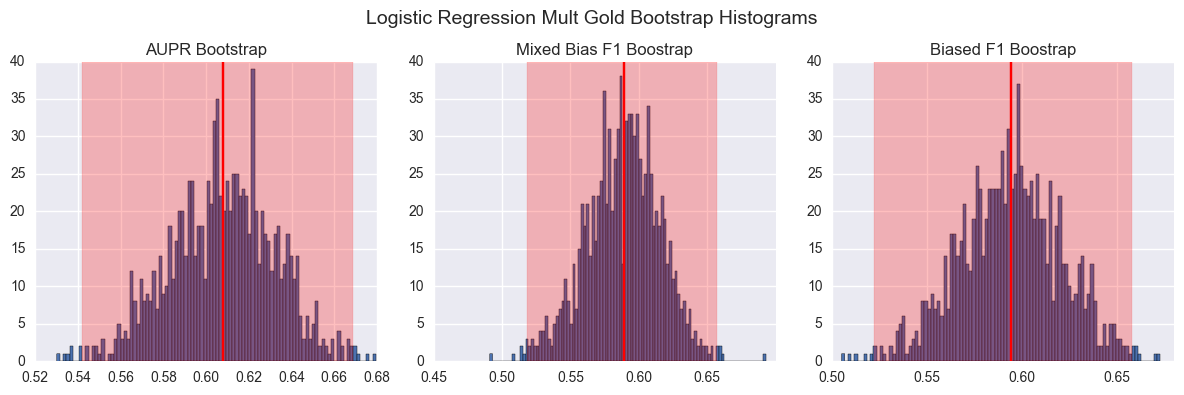

In [61]:
start = time.time()
title = 'Logistic Regression Mult Gold'
all_results[title] = model_report(best_mult_lr_gold, title, 'is_multiple',
                   save_fname='figures/mult_lr_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 558 seconds


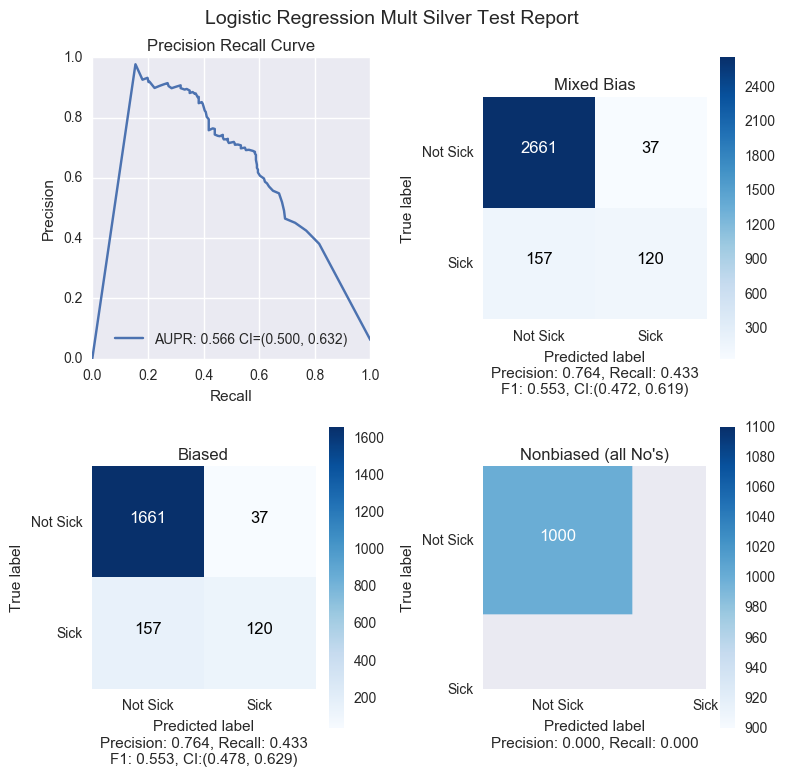

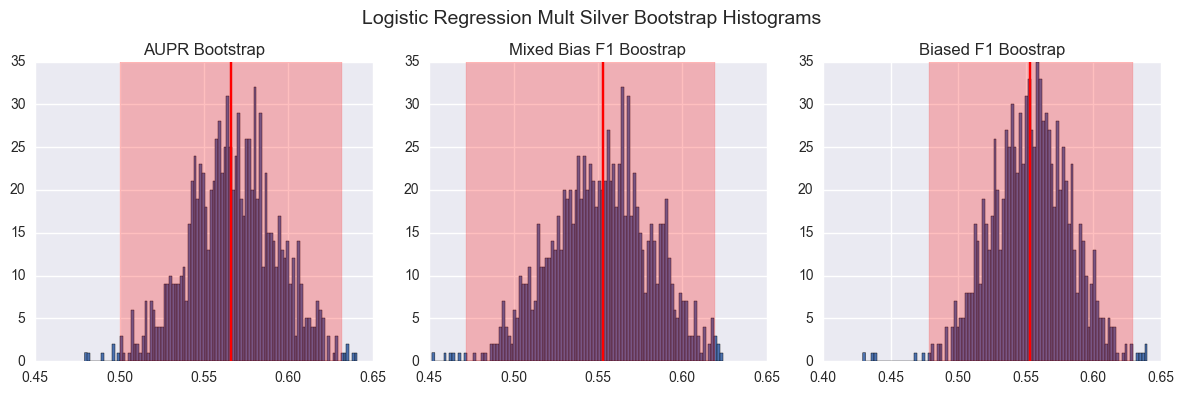

In [62]:
start = time.time()
title = 'Logistic Regression Mult Silver'
all_results[title] = model_report(best_mult_lr_silver, title, 'is_multiple',
                   save_fname='figures/mult_lr_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [36]:
print_model_hyperparams(best_mult_lr_biased, 'Logistic Regression Mult Biased')
print
print_model_hyperparams(best_mult_lr_gold, 'Logistic Regression Mult Gold')
print
print_model_hyperparams(best_mult_lr_silver, 'Logistic Regression Mult Silver')
print

*** Logistic Regression Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.89510489382036751,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 16.866411904124611,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': 'l2

### Random Forest

In [37]:
best_mult_rf_biased = joblib.load('experiments/best_models/best_rf_mult_biased.pkl')
best_mult_rf_gold = joblib.load('experiments/best_models/best_rf_mult_gold.pkl')
best_mult_rf_silver = joblib.load('experiments/best_models/best_rf_mult_silver.pkl')

In [38]:
best_mult_rf_biased.fit(biased_text, biased_mult, rf__sample_weight=biased_weights)
best_mult_rf_gold.fit(gold_text, gold_mult, rf__sample_weight=gold_weights)
best_mult_rf_silver.fit(silver_text, silver_mult, rf__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.80352618636857176, max_features=1000,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words...estimators=194, n_jobs=4, oob_score=True, random_state=0,
            verbose=0, warm_start=False))])


B: 999/1000
B: 999/1000
B: 999/1000 553 seconds


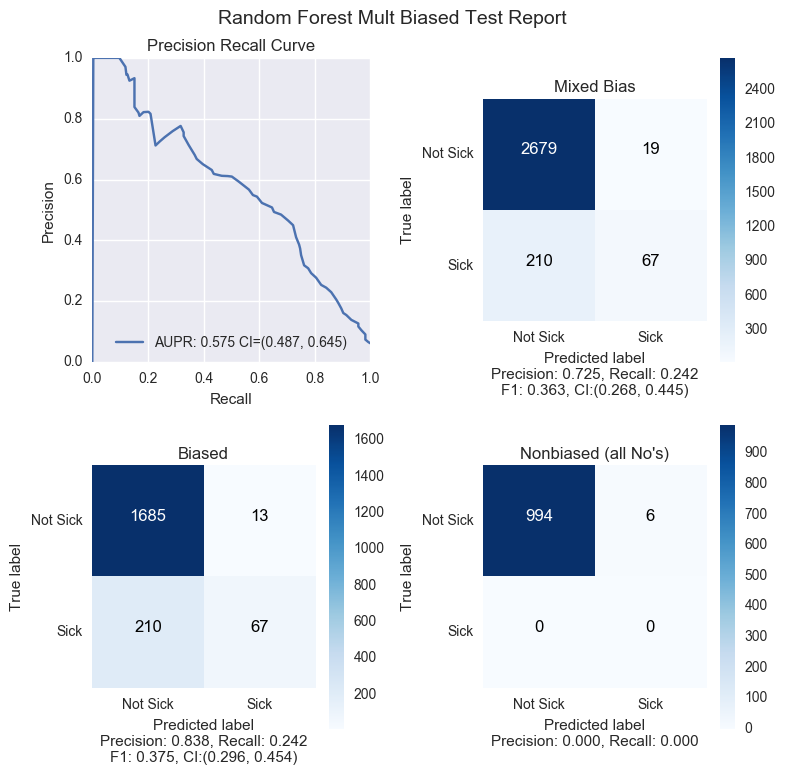

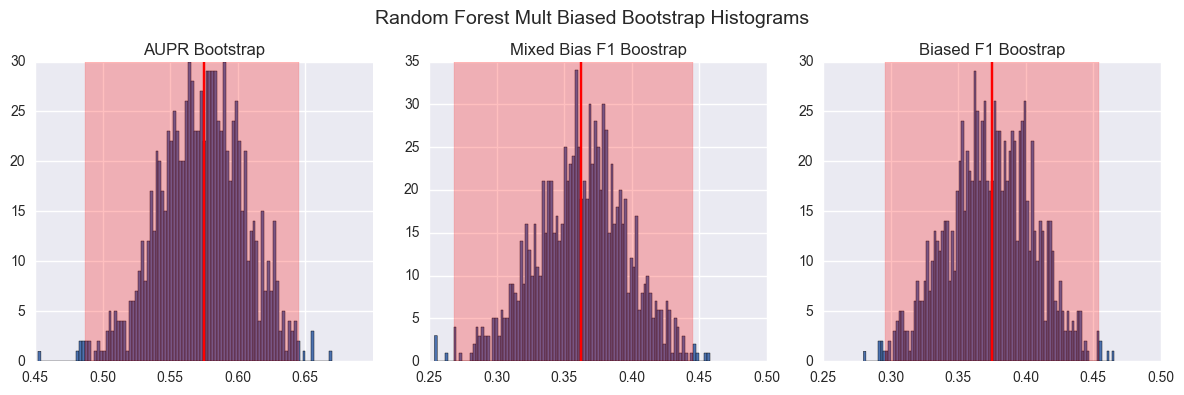

In [63]:
start = time.time()
title = 'Random Forest Mult Biased'
all_results[title] = model_report(best_mult_rf_biased, title, 'is_multiple',
                   save_fname='figures/mult_rf_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 546 seconds


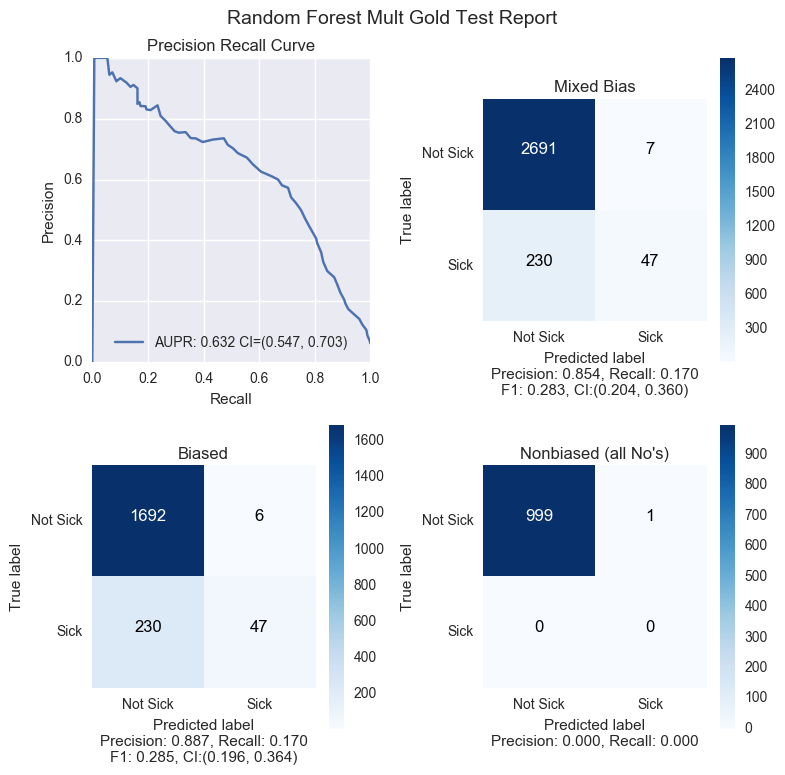

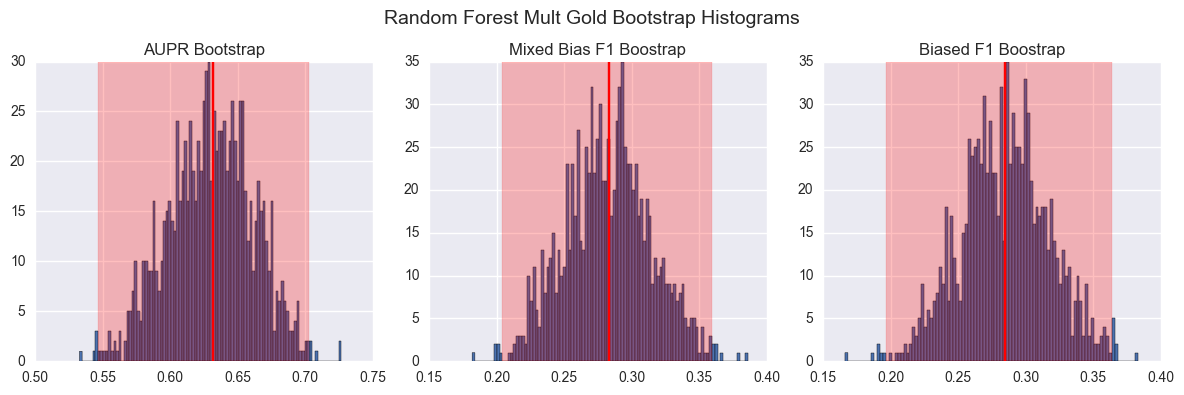

In [64]:
start = time.time()
title = 'Random Forest Mult Gold'
all_results[title] = model_report(best_mult_rf_gold, title, 'is_multiple',
                   save_fname='figures/mult_rf_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 552 seconds


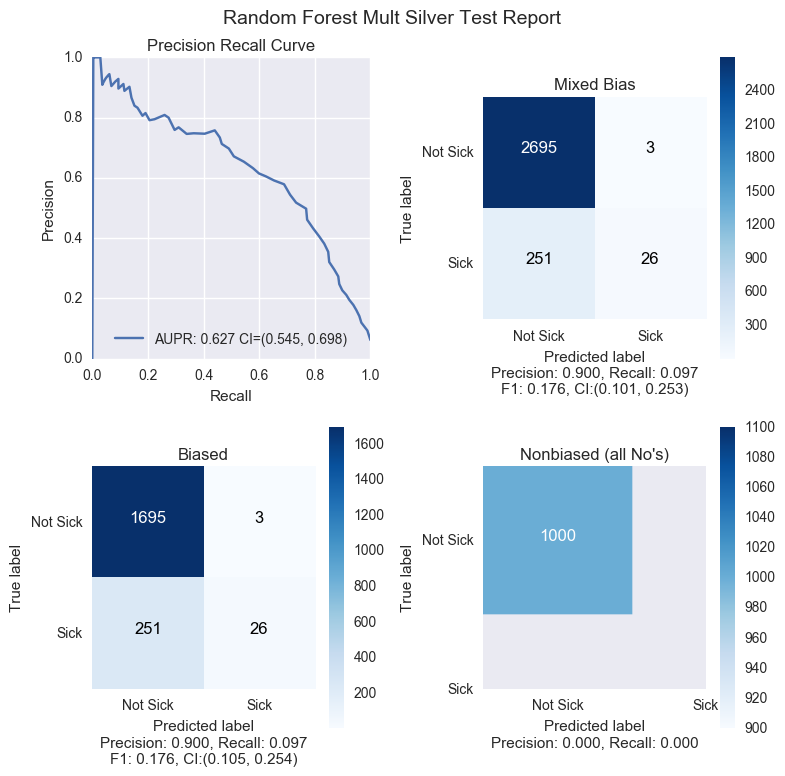

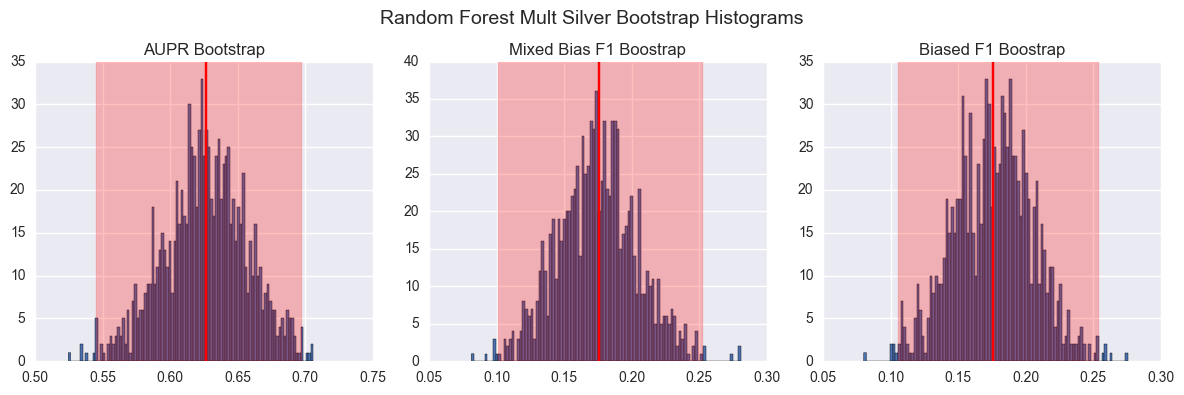

In [65]:
start = time.time()
title = 'Random Forest Mult Silver'
all_results[title] = model_report(best_mult_rf_silver, title, 'is_multiple',
                   save_fname='figures/mult_rf_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [42]:
print_model_hyperparams(best_mult_rf_biased, 'Random Forest Mult Biased')
print
print_model_hyperparams(best_mult_rf_gold, 'Random Forest Mult Gold')
print
print_model_hyperparams(best_mult_rf_silver, 'Random Forest Mult Silver')
print

*** Random Forest Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.91095818181620702,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 167,
 'rf__n_jobs': 4,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### SVM

In [43]:
best_mult_svm_biased = joblib.load('experiments/best_models/best_svm_mult_biased.pkl')
best_mult_svm_gold = joblib.load('experiments/best_models/best_svm_mult_gold.pkl')
best_mult_svm_silver = joblib.load('experiments/best_models/best_svm_mult_silver.pkl')

In [44]:
best_mult_svm_biased.fit(biased_text, biased_mult, svc__sample_weight=biased_weights)
best_mult_svm_gold.fit(gold_text, gold_mult, svc__sample_weight=gold_weights)
best_mult_svm_silver.fit(silver_text, silver_mult, svc__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.84144420079219573, max_features=None,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


B: 999/1000
B: 999/1000
B: 999/1000 556 seconds


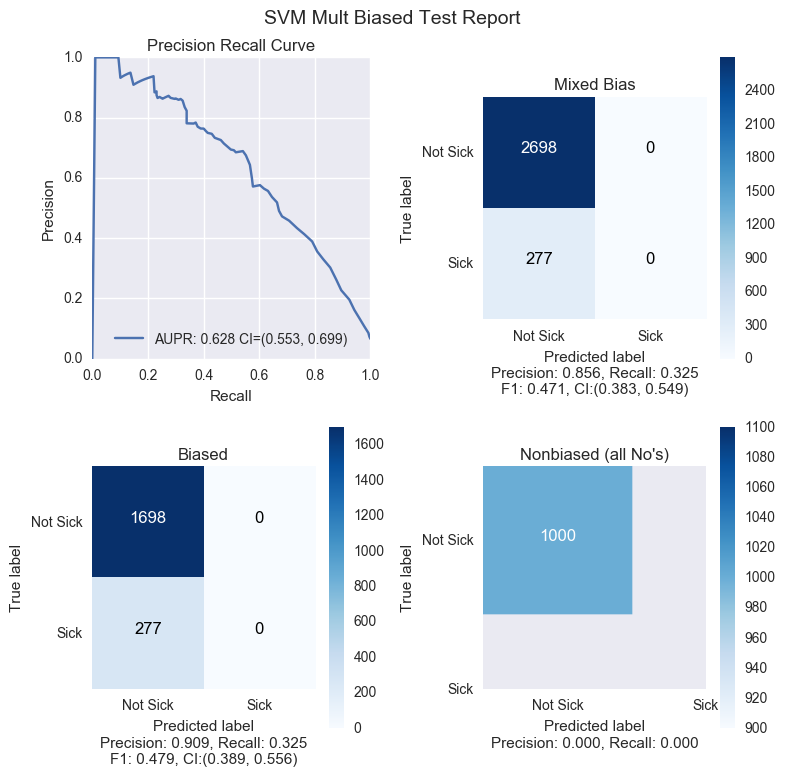

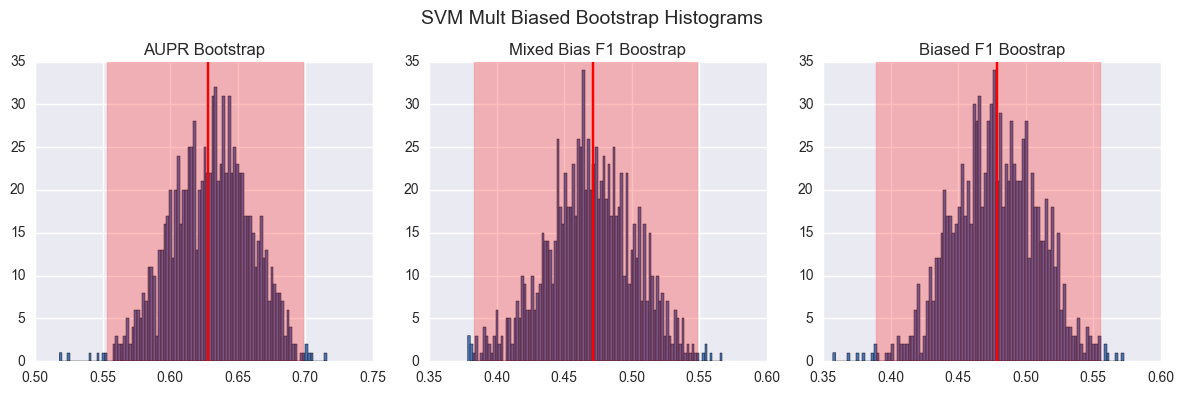

In [66]:
start = time.time()
title = 'SVM Mult Biased'
all_results[title] = model_report(best_mult_svm_biased, title, 'is_multiple',
                   save_fname='figures/mult_svm_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 576 seconds


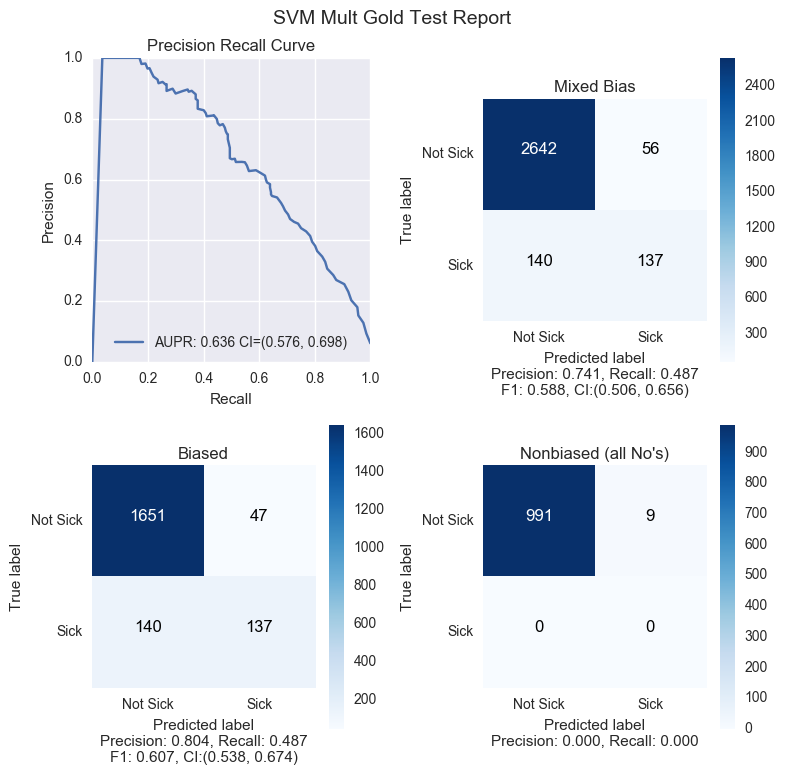

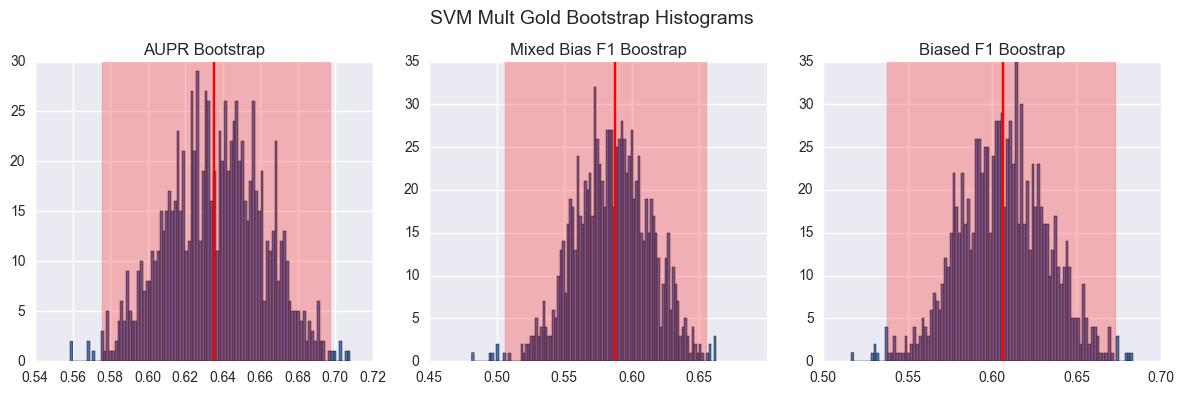

In [67]:
start = time.time()
title = 'SVM Mult Gold'
all_results[title] = model_report(best_mult_svm_gold, title, 'is_multiple',
                   save_fname='figures/mult_svm_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 999/1000
B: 999/1000
B: 999/1000 566 seconds


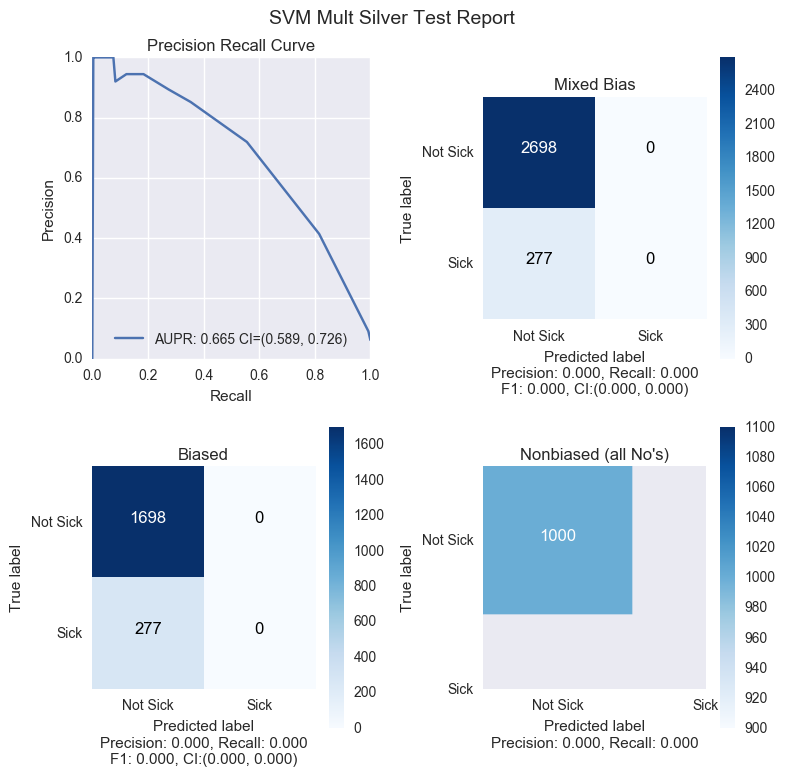

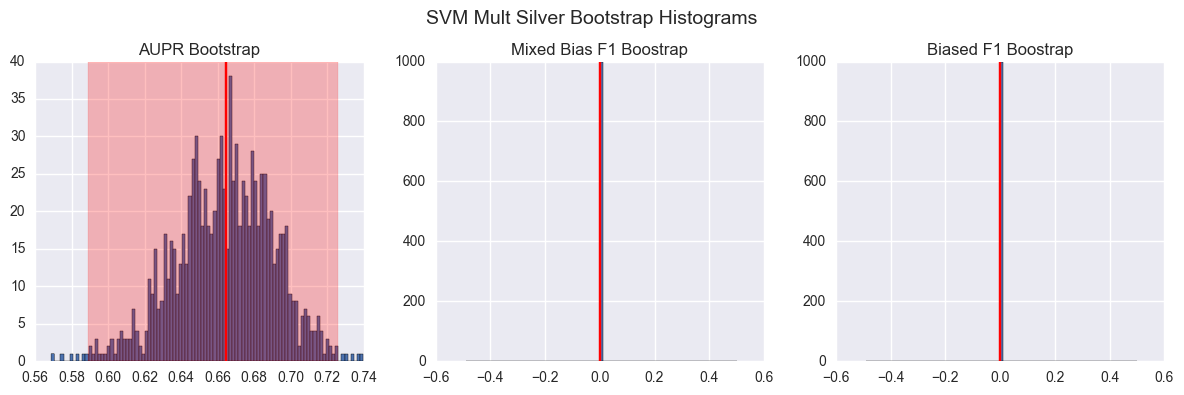

In [68]:
start = time.time()
title = 'SVM Mult Silver'
all_results[title] = model_report(best_mult_svm_silver, title, 'is_multiple',
                   save_fname='figures/mult_svm_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [48]:
print_model_hyperparams(best_mult_svm_biased, 'SVM Mult Biased')
print
print_model_hyperparams(best_mult_svm_gold, 'SVM Mult Gold')
print
print_model_hyperparams(best_mult_svm_silver, 'SVM Mult Silver')
print

*** SVM Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.77321625014344464,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 0.55052123745597503,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False

In [73]:
# what happens if we do 95% intervals instead of 99%
for name, result in all_results.items():
    result['aupr_ci_95'] = ci(result['aupr'], result['aupr_samples'], .95)
    result['biased_f1_ci_95'] = ci(result['biased_f1'], result['biased_f1_samples'], .95)
    result['mixed_f1_ci_95'] = ci(result['mixed_f1'], result['mixed_f1_samples'], .95)

In [212]:
pprint(all_results.values()[0].keys())

['aupr_ci',
 'mixed_f1_ci',
 'aupr_ci_95',
 'mixed_precision',
 'biased_recall',
 'biased_precision',
 'mixed_recall',
 'aupr',
 'mixed_f1',
 'biased_f1',
 'biased_f1_ci',
 'biased_f1_ci_95',
 'mixed_f1_ci_95',
 'mixed_f1_samples',
 'biased_f1_samples',
 'aupr_samples']


In [216]:
sick_table = pd.DataFrame()
mult_table = pd.DataFrame()
for name, result in sorted(all_results.items(), key=lambda x:x[0]):
#     print result.keys()
    data = {k:v for k,v in result.items() if ('samples' not in k) and ('_ci' not in k) }
#     print data.keys()
    data.update({k+'_b':v[0] for k,v in result.items() if '_ci' in k})
    data.update({k+'_t':v[1] for k,v in result.items() if '_ci' in k})
    data['name'] = name
    if 'Sick' in name:
        sick_table = sick_table.append(data, ignore_index=True)
    else:
        mult_table = mult_table.append(data, ignore_index=True)
sick_table.set_index('name', inplace=True)
mult_table.set_index('name', inplace=True)

In [217]:
print sick_table.columns

Index([u'aupr', u'aupr_ci_b', u'aupr_ci_t', u'biased_f1', u'biased_f1_ci_b',
       u'biased_f1_ci_t', u'biased_precision', u'biased_recall', u'mixed_f1',
       u'mixed_f1_ci_b', u'mixed_f1_ci_t', u'mixed_precision', u'mixed_recall',
       u'aupr_ci_95_b', u'aupr_ci_95_t', u'biased_f1_ci_95_b',
       u'biased_f1_ci_95_t', u'mixed_f1_ci_95_b', u'mixed_f1_ci_95_t'],
      dtype='object')


In [239]:
sick_table.to_csv('baseline_sick_results.csv')
sick_table[['mixed_f1', 'mixed_f1_ci_95_b', 'mixed_f1_ci_95_t']]

mixed_f1  mixed_f1_ci_95_b  \
name                                                                          
Logistic Regression - Sick Only Biased Multiple  0.594689               NaN   
Logistic Regression - Sick Only Silver Multiple  0.625277               NaN   
Logistic Regression Sick Biased                  0.810384          0.791781   
Logistic Regression Sick Gold                    0.829657          0.811829   
Logistic Regression Sick Silver                  0.842672          0.825121   
Random Forest Sick Biased                        0.747063          0.723563   
Random Forest Sick Gold                          0.821471          0.804113   
Random Forest Sick Silver                        0.833849          0.815536   
SVM Sick Biased                                  0.700309          0.678325   
SVM Sick Gold                                    0.838964          0.821037   
SVM Sick Silver                                  0.010482          0.002085   

                                                 mixed_f1_ci_95_t  
name                                                               
Logistic Regression - Sick Only Biased Multiple               NaN  
Logistic Regression - Sick Only Silver Multiple               NaN  
Logistic Regression Sick Biased                          0.832144  
Logistic Regression Sick Gold                            0.845080  
Logistic Regression Sick Silver                          0.859133  
Random Forest Sick Biased                                0.768220  
Random Forest Sick Gold                                  0.839736  
Random Forest Sick Silver                                0.850566  
SVM Sick Biased                                          0.721283  
SVM Sick Gold                                            0.858323  
SVM Sick Silver                                          0.020856

In [225]:
mult_table.to_csv('baseline_mult_results.csv')
mult_table[['aupr', 'aupr_ci_95_b', 'aupr_ci_95_t']]

aupr  aupr_ci_95_b  aupr_ci_95_t
name                                                                 
Logistic Regression Mult Biased  0.629335      0.575553      0.687136
Logistic Regression Mult Gold    0.607892      0.559657      0.652928
Logistic Regression Mult Silver  0.566155      0.514807      0.618194
Random Forest Mult Biased        0.575024      0.508092      0.631559
Random Forest Mult Gold          0.631710      0.569606      0.688517
Random Forest Mult Silver        0.626728      0.561665      0.687391
SVM Mult Biased                  0.628311      0.571960      0.683881
SVM Mult Gold                    0.635508      0.586247      0.686020
SVM Mult Silver                  0.664662      0.607319      0.713526

In [78]:
best_sick_model = best_sick_lr_silver
best_mult_model = best_mult_lr_biased

## Best Params

In [81]:
pprint(best_sick_model.get_params())

{'count': CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.92876195959267271, max_features=None,
        min_df=1, ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None),
 'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.92876195959267271,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg': LogisticRegression(C=9.7498716797727401, class_weight=Non

In [82]:
pprint(best_mult_model.get_params())

{'count': CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.89510489382036751, max_features=None,
        min_df=1, ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None),
 'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.89510489382036751,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg': LogisticRegression(C=16.866411904124611, class_weight=Non

# Error Analysis

We analyze error for the best models:
* Sick: Logistic Regression Silver
* Multiple: Logistic Regression Mult Biased

### Sick

In [79]:
y_trues = np.array(test_data['is_foodborne'])
preds = best_sick_model.predict_proba(test_data['text'])[:,1]
sick_errors = (preds > .5) != y_trues

sick_error_df = pd.DataFrame({
        'text':np.array(test_data['text'])[sick_errors],
        'y_true':y_trues[sick_errors],
        'prob':preds[sick_errors],
        'is_biased':np.array(test_data['is_biased'])[sick_errors]
    })
sick_error_df['error_type'] = ""
sick_error_df['comments'] = ""
print len(sick_error_df), ' to analyze'
sick_error_df = sick_error_df.sample(frac=1, random_state=0).reset_index(drop=True)
sick_error_df.to_excel('sick_errors_to_analyze.xlsx', encoding="utf8", header=True, index=True)

292  to analyze


### Multiple

In [80]:
y_trues = np.array(test_data['is_multiple'])
preds = best_mult_model.predict_proba(test_data['text'])[:,1]
mult_errors = (preds > .5) != y_trues

mult_error_df = pd.DataFrame({
        'text':np.array(test_data['text'])[mult_errors],
        'y_true':y_trues[mult_errors],
        'prob':preds[mult_errors],
        'is_biased':np.array(test_data['is_biased'])[mult_errors]
    })
mult_error_df['error_type'] = ""
mult_error_df['comments'] = ""
print len(mult_error_df), ' to analyze'
# shuffle them and do as many as possible
mult_error_df = mult_error_df.sample(frac=1, random_state=0).reset_index(drop=True)
mult_error_df.to_excel('mult_errors_to_analyze.xlsx', encoding="utf8", header=True, index=True)

176  to analyze


## Inspecting Model Weights

The two winning baseline models were the logistic regression on silver data for sick and on biased data for multiple.
These results don't necessarily agree. But we suspect that there is an obvious reason for this:

The Sick task is mostly approachable with ngrams, so we suspect we will see that the model weights will reflect useful ngrams for the task (e.g., 'got food poisoning' and 'sick of') and so the additional data serves to regularize some statistical quirks of the training data.

The Multiple task, however, is significantly more difficult (if not mostly impossible) to model using ngrams, and so we suspect that our model will have learned a disjunctive hypothesis that looks for either sick ngrams or ngrams which discuss multiple people. Since there are many ngrams discussing multiple people in the gold and silver negative data, the addition of this data would drown out the (incorrect) signal in the biased training data. So in fact this model will likely be less appropriate as it will overly rely on mentions of multiple people.

If this were true, we would expect to see a couple of things:
* The Sick Silver model has reasonable top features
* The Sick Biased model is overfit (less reasonable top features)
* The Mult Silver model does not have reasonable top features (they reflect disjunctive hypothesis)
* The Mult Biased model also does not have reasonable top features (they reflect disjunctive hypothesis)
* The Sick model is about as predictive on the Mult data as the silver standard Mult model
* Conversely, the silver standard Mult model should perform reasonably on the Sick task, but the biased will not.

In [115]:
def print_top_features(model_weights, idx2featurename, k=50):
    top_feature_idxs = np.argsort(np.abs(model_weights))[::-1]
    print 'Top Features'
    print 'Rank: {0:<20}  |  Weight'.format('Ngram')
    print '-'*50
    for i, idx in enumerate(top_feature_idxs[:k]):
        print '{0:<4}: {1:<20}  |  {2:2.2f}'.format(i+1, idx2featurename[idx], model_weights[idx])

### Sick Silver Top Features

In [261]:
model_weights = best_sick_model.steps[2][1].coef_.ravel()
idx2ngram = {i:v for v,i in best_sick_model.steps[0][1].vocabulary_.items()}

In [263]:
print_top_features(model_weights, idx2ngram, 50)

Top Features
Rank: Ngram                 |  Weight
--------------------------------------------------
1   : diarrhea              |  4.46
2   : sick                  |  4.44
3   : poisoning             |  3.32
4   : food poisoning        |  2.88
5   : vomiting              |  2.06
6   : poisoned              |  1.29
7   : got food              |  1.29
8   : poison                |  1.19
9   : food poison           |  1.16
10  : food poisoned         |  1.16
11  : got sick              |  1.05
12  : stomach               |  0.99
13  : amazing               |  -0.80
14  : got                   |  0.80
15  : sick after            |  0.73
16  : sick for              |  0.72
17  : sick from             |  0.70
18  : later                 |  0.70
19  : felt sick             |  0.68
20  : sick of               |  -0.67
21  : made me               |  0.65
22  : yesterday             |  0.64
23  : afterwards            |  0.62
24  : had diarrhea          |  0.62
25  : very sick             |  0

### Sick Biased Top Features

In [124]:
model_weights = best_sick_lr_biased.steps[2][1].coef_.ravel()
idx2ngram = {i:v for v,i in best_sick_lr_biased.steps[0][1].vocabulary_.items()}

In [125]:
print_top_features(model_weights, idx2ngram, 20)

Top Features
Rank: Ngram                 |  Weight
--------------------------------------------------
1   : food poisoning        |  8.17
2   : poisoning             |  8.05
3   : got                   |  6.61
4   : food                  |  6.49
5   : sick of               |  -4.35
6   : diarrhea              |  4.16
7   : got food              |  4.04
8   : is                    |  -4.03
9   : get                   |  -3.94
10  : got food poisoning    |  3.53
11  : stomach               |  3.51
12  : got sick              |  3.51
13  : ate                   |  3.48
14  : after                 |  3.45
15  : night                 |  3.44
16  : from                  |  3.29
17  : get sick              |  -3.25
18  : you                   |  -3.22
19  : had                   |  3.11
20  : hours                 |  2.94


### Mult Silver Top Features

In [200]:
model_weights = best_mult_lr_silver.steps[2][1].coef_.ravel()
idx2ngram = {i:v for v,i in best_mult_lr_silver.steps[0][1].vocabulary_.items()}

In [201]:
print_top_features(model_weights, idx2ngram, 50)

Top Features
Rank: Ngram                 |  Weight
--------------------------------------------------
1   : sick                  |  36.42
2   : both                  |  29.98
3   : diarrhea              |  23.63
4   : me and                |  22.19
5   : of us                 |  19.93
6   : my                    |  17.71
7   : we both               |  17.45
8   : we                    |  16.79
9   : all got               |  16.43
10  : we all                |  14.98
11  : us sick               |  14.39
12  : got food              |  13.79
13  : and both              |  13.65
14  : friend and            |  13.52
15  : both got              |  13.47
16  : both my               |  11.77
17  : stomachs              |  11.58
18  : friend                |  11.48
19  : husband and           |  11.33
20  : us                    |  11.31
21  : with food             |  10.92
22  : we got                |  10.84
23  : were sick             |  10.81
24  : stomach               |  10.77
25  : us g

### Mult Biased Top Features

In [202]:
model_weights = best_mult_lr_biased.steps[2][1].coef_.ravel()
idx2ngram = {i:v for v,i in best_mult_lr_biased.steps[0][1].vocabulary_.items()}

In [203]:
print_top_features(model_weights, idx2ngram, 50)

Top Features
Rank: Ngram                 |  Weight
--------------------------------------------------
1   : both                  |  19.15
2   : we                    |  16.31
3   : of us                 |  10.94
4   : my                    |  10.22
5   : me and                |  9.64
6   : we both               |  9.24
7   : us                    |  9.09
8   : me and my             |  8.97
9   : we all                |  7.45
10  : friend                |  6.88
11  : and both              |  6.82
12  : both got              |  6.79
13  : friend and            |  6.74
14  : and my                |  6.42
15  : all got               |  6.33
16  : family                |  5.84
17  : diarrhea              |  5.81
18  : party                 |  5.76
19  : friends               |  5.59
20  : husband               |  5.52
21  : all                   |  5.52
22  : both my               |  5.46
23  : husband and           |  5.26
24  : my friend and         |  5.21
25  : we got                | 

### Mult model trained on Sick subset

Since the Multiple is always conditioned on Sick=Yes (by definition), it makes more sense to train and use the Multuple model only on data where Sick=Yes. This may allow the model to focus better on Multiple-related features (at least ideally) but also may not work do to the limitations of 3-grams

In [142]:
from copy import deepcopy

In [164]:
class MultPipeline():
    def __init__(self, sick_model, mult_model):
        self.sick_model = sick_model
        self.mult_model = mult_model
    
    def predict_proba(self, xs):
        sick_probs = self.sick_model.predict_proba(xs)
        not_sick = sick_probs[:,1] < .5
        mult_probs = self.mult_model.predict_proba(xs)
        mult_probs[not_sick] = sick_probs[not_sick]
        return mult_probs
    
    def predict(self, xs):
        return (self.predict_proba(xs)[:,1] >= .5).astype(np.int32)

#### Mult Biased

In [159]:
sick_only = biased_sick.astype(np.bool)
sick_only_text = biased_text[sick_only]
sick_only_mult = biased_mult[sick_only]
sick_only_weights = biased_weights[sick_only]
print "{} training data / {} orginally".format(len(sick_only_text), len(biased_text))
print "{0:2.2f}% yes, {1:2.2f}% biased".format(
    100.*sick_only_mult.sum()/len(sick_only_mult), 
    100.*np.array(biased_data['train_data']['is_biased'])[sick_only].sum()/len(sick_only_mult), 
)

5899 training data / 11566 orginally
24.83% yes, 100.00% biased


In [160]:
sick_only_mult_lr_biased = deepcopy(best_mult_lr_biased)

In [174]:
sick_only_mult_lr_biased.fit(sick_only_text, sick_only_mult, logreg__sample_weight=sick_only_weights)
sick_only_mult_model_biased = MultPipeline(best_sick_lr_biased, sick_only_mult_lr_biased)


B: 999/1000
B: 999/1000
B: 999/1000


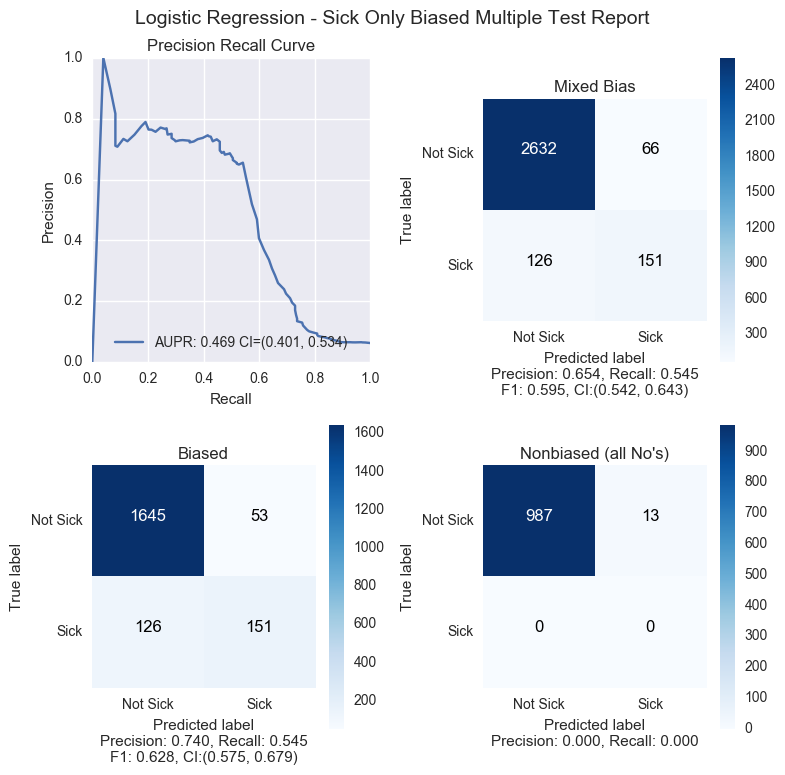

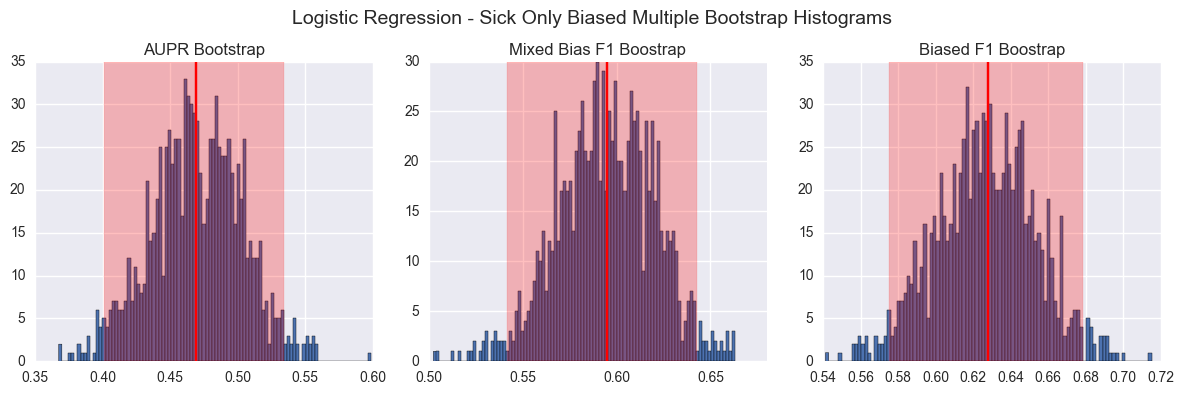

In [175]:
title = 'Logistic Regression - Sick Only Biased Multiple'
all_results[title] = model_report(sick_only_mult_model_biased, title, 'is_multiple', B=1000)

#### Mult Gold

In [241]:
sick_only = gold_sick.astype(np.bool)
sick_only_text = gold_text[sick_only]
sick_only_mult = gold_mult[sick_only]
sick_only_weights = gold_weights[sick_only]
print "{} training data / {} orginally".format(len(sick_only_text), len(gold_text))
print "{0:2.2f}% yes, {1:2.2f}% biased".format(
    100.*sick_only_mult.sum()/len(sick_only_mult), 
    100.*np.array(gold_data['train_data']['is_biased'])[sick_only].sum()/len(sick_only_mult), 
)

5903 training data / 12566 orginally
24.83% yes, 99.93% biased


In [242]:
sick_only_mult_lr_gold = deepcopy(best_mult_lr_gold)

In [243]:
sick_only_mult_lr_gold.fit(sick_only_text, sick_only_mult, logreg__sample_weight=sick_only_weights)
sick_only_mult_model_gold = MultPipeline(best_sick_lr_gold, sick_only_mult_lr_gold)


B: 999/1000
B: 999/1000
B: 999/1000


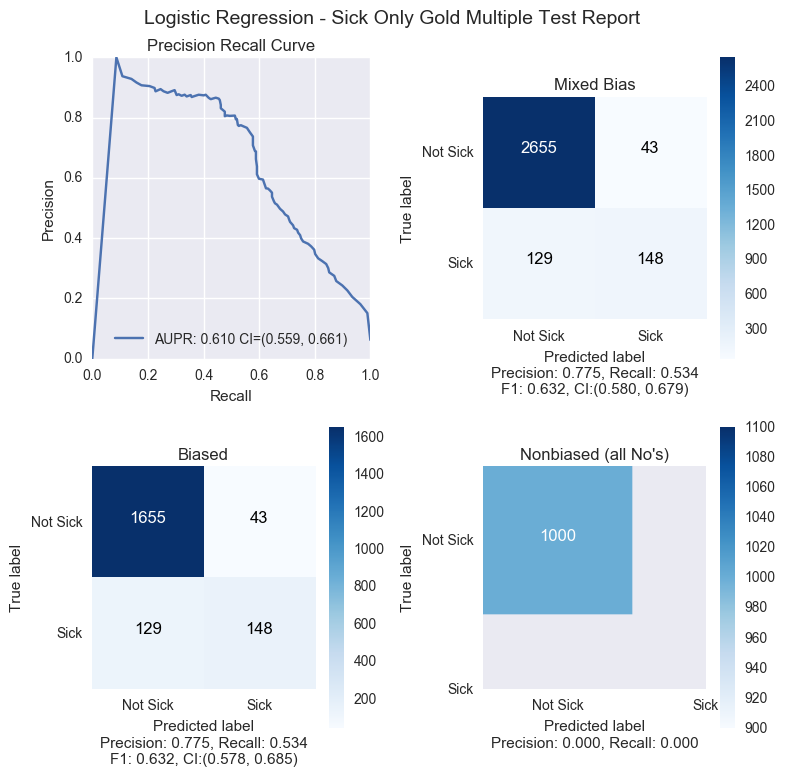

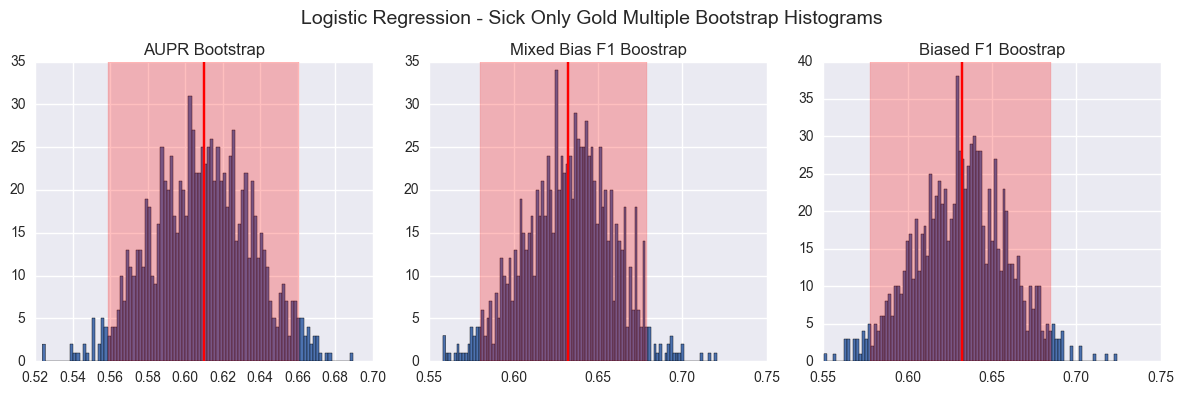

In [245]:
title = 'Logistic Regression - Sick Only Gold Multiple'
all_results[title] = model_report(sick_only_mult_model_gold, title, 'is_multiple', B=1000)

#### Mult Silver

In [176]:
sick_only = silver_sick.astype(np.bool)
sick_only_text = silver_text[sick_only]
sick_only_mult = silver_mult[sick_only]
sick_only_weights = silver_weights[sick_only]
print "{} training data / {} orginally".format(len(sick_only_text), len(silver_text))
print "{0:2.2f}% yes, {1:2.2f}% biased".format(
    100.*sick_only_mult.sum()/len(sick_only_mult), 
    100.*np.array(silver_data['train_data']['is_biased'])[sick_only].sum()/len(sick_only_mult), 
)

5899 training data / 21566 orginally
24.83% yes, 100.00% biased


In [249]:
sick_only_mult_lr_silver = deepcopy(best_mult_lr_silver)

In [250]:
sick_only_mult_lr_silver.fit(sick_only_text, sick_only_mult, logreg__sample_weight=sick_only_weights)
sick_only_mult_model_silver = MultPipeline(best_sick_lr_silver, sick_only_mult_lr_silver)

In [251]:
print len(biased_text)

11566



B: 999/1000
B: 999/1000
B: 999/1000


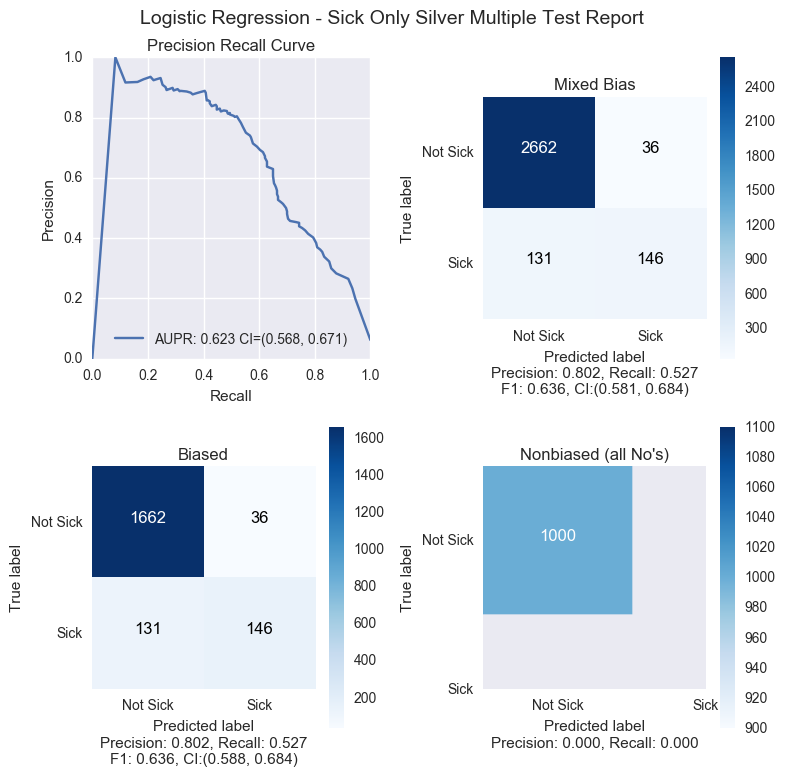

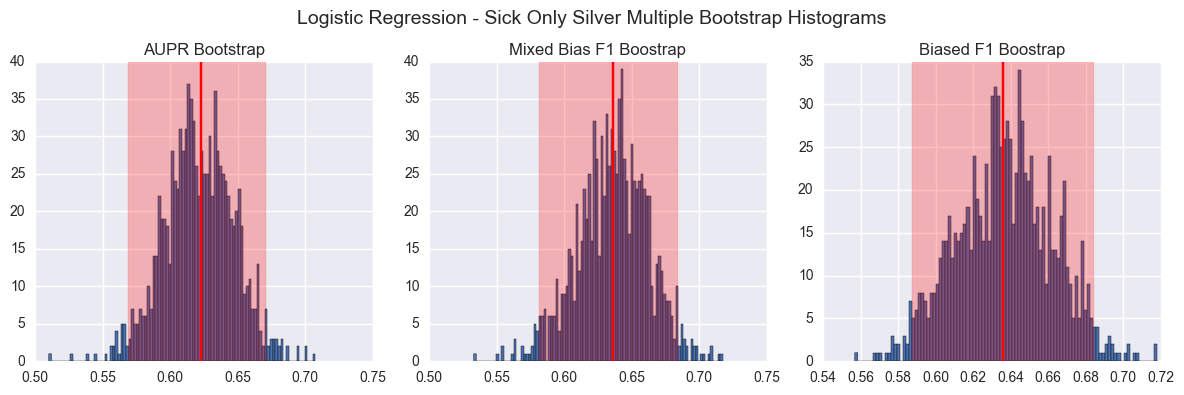

In [252]:
title = 'Logistic Regression - Sick Only Silver Multiple'
all_results[title] = model_report(sick_only_mult_model_silver, title, 'is_multiple', B=1000)

In [253]:
# check out the top features

In [254]:
model_weights = sick_only_mult_lr_silver.steps[2][1].coef_.ravel()
idx2ngram = {i:v for v,i in sick_only_mult_lr_silver.steps[0][1].vocabulary_.items()}

In [258]:
print_top_features(model_weights, idx2ngram, 50)

Top Features
Rank: Ngram                 |  Weight
--------------------------------------------------
1   : we                    |  26.38
2   : both                  |  25.80
3   : us                    |  13.96
4   : of us                 |  13.90
5   : me and                |  13.49
6   : my                    |  13.28
7   : me and my             |  11.86
8   : we both               |  11.22
9   : friend                |  10.14
10  : we all                |  10.08
11  : friend and            |  9.76
12  : and both              |  9.64
13  : family                |  9.33
14  : people                |  8.90
15  : both got              |  8.60
16  : friends               |  8.25
17  : all                   |  8.19
18  : husband and           |  8.07
19  : party                 |  7.94
20  : all got               |  7.85
21  : and my                |  7.55
22  : my friend and         |  7.54
23  : we got                |  7.42
24  : husband               |  7.22
25  : both my           

In [182]:
print len(biased_sick)+ np.array(test_data['is_biased']).sum()

13541


### Write out the final Sick and Multiple classifiers -- Sick LR Silver and Mult LR Pipelined Silver

In [265]:
from sklearn.externals import joblib
joblib.dump(sick_only_mult_lr_silver, 'final_yelp_mult_model.gz')
joblib.dump(best_sick_lr_silver, 'final_yelp_sick_model.gz')

['final_yelp_sick_model.gz']

In [268]:
final_mult_model = joblib.load('final_yelp_models/final_yelp_mult_model.gz')

In [267]:
final_sick_model = joblib.load('final_yelp_models/final_yelp_sick_model.gz')

In [ ]:
from sklearn.externals import joblib
final_sick_model = joblib.load('final_yelp_models/final_yelp_sick_model.gz')
final_mult_model = joblib.load('final_yelp_models/final_yelp_mult_model.gz')

In [31]:

lr_sick_biased_errors = best_sick_lr_biased.predict(test_data['text']) != y_trues
lr_sick_gold_errors = best_sick_lr_gold.predict(test_data['text']) != y_trues
lr_sick_silver_errors = best_sick_lr_silver.predict(test_data['text']) != y_trues

rf_sick_biased_errors = best_sick_rf_biased.predict(test_data['text']) != y_trues
rf_sick_gold_errors = best_sick_rf_gold.predict(test_data['text']) != y_trues
rf_sick_silver_errors = best_sick_rf_silver.predict(test_data['text']) != y_trues

svm_sick_biased_errors = best_sick_svm_biased.predict(test_data['text']) != y_trues
svm_sick_gold_errors = best_sick_svm_gold.predict(test_data['text']) != y_trues
svm_sick_silver_errors = best_sick_svm_silver.predict(test_data['text']) != y_trues

In [62]:
errors = pd.DataFrame({
        'lr_sick_biased':lr_sick_biased_errors,
        'lr_sick_gold':lr_sick_gold_errors,
        'lr_sick_silver':lr_sick_silver_errors,
        'rf_sick_biased':rf_sick_biased_errors,
        'rf_sick_gold':rf_sick_gold_errors,
        'rf_sick_silver':rf_sick_silver_errors,
        'svm_sick_biased':svm_sick_biased_errors,
        'svm_sick_gold':svm_sick_gold_errors,
        'svm_sick_silver':svm_sick_silver_errors,
        'true_label':y_trues,
        'is_biased':test_data['is_biased'],
        'text':test_data['text']
    })

In [63]:
for col in errors.columns:
    if 'sick' in col:
        print errors[col].value_counts()
        print 

False    2628
True      347
Name: lr_sick_biased, dtype: int64

False    2670
True      305
Name: lr_sick_gold, dtype: int64

False    2678
True      297
Name: lr_sick_silver, dtype: int64

False    2532
True      443
Name: rf_sick_biased, dtype: int64

False    2606
True      369
Name: rf_sick_gold, dtype: int64

False    2631
True      344
Name: rf_sick_silver, dtype: int64

False    2387
True      588
Name: svm_sick_biased, dtype: int64

False    2656
True      319
Name: svm_sick_gold, dtype: int64

False    2026
True      949
Name: svm_sick_silver, dtype: int64



In [52]:
errors['total'] = errors.sum(axis=1)

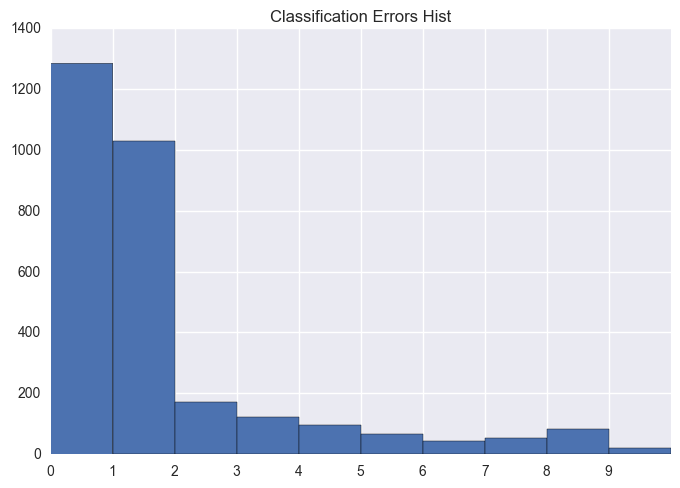

In [59]:
counts, bin_edges, _ = plt.hist(errors.total, bins=np.arange(11))
plt.xticks(np.arange(10))
plt.title('Classification Errors Hist')

In [51]:
for i, count in zip(range(len(counts)), counts):
    print '{} examples were mistaken by {}/9 classifiers'.format(int(count), i)

1284 examples were mistaken by 0/9 classifiers
1030 examples were mistaken by 1/9 classifiers
173 examples were mistaken by 2/9 classifiers
123 examples were mistaken by 3/9 classifiers
95 examples were mistaken by 4/9 classifiers
68 examples were mistaken by 5/9 classifiers
45 examples were mistaken by 6/9 classifiers
52 examples were mistaken by 7/9 classifiers
83 examples were mistaken by 8/9 classifiers
22 examples were mistaken by 9/9 classifiers


In [228]:
print 'List<String> texts = Arrays.asList("{}");'.format('", "'.join([t.replace('\n',' ').replace('"','\\"').encode('utf8')
                                                                   for t in test_data['text']]))

List<String> texts = Arrays.asList("Great looking restaurant. Staff was attentive and competent. Beer selection was great. Spreads to get started were tasty and lots of free Pita.   While there were six of us for dinner, four of us enjoyed the meal and two of us, who ordered the tiger shrimp, had several days of misery afterwards. The shrimp was no good and made my wife and a  Friends wife very sick. Unfortunately that overwhelms the rest of the experience.", "I'm writing this review sitting on my toilet, because they gave me warm chicken nuggets, almost cold, and everyone knows that the food must be kept hot so it Don't get bacteria, so now I have food poisoning,  I went in the driveway to buy popeye chicken, then suddenly I was in the burger king drive through. I just needed a quick snack so I just got the nuggets. This is my 3rd time in the toilet and is 2AM., not too happy.", "Staff has the most disgusting attitude, and make you feel unwanted at the place if they don't know you on 

In [229]:
old_sick_scores = [ 0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.9705882352941176,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.9705882352941176,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9705882352941176,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9705882352941176,
0.002277904328018223,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9230769230769231,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9230769230769231,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9230769230769231,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.9230769230769231,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9705882352941176,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9230769230769231,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.9705882352941176,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.9705882352941176,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9705882352941176,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9230769230769231,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9705882352941176,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9705882352941176,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.9230769230769231,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9705882352941176,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.002277904328018223,
0.9829351535836177,
0.9829351535836177,
0.002277904328018223,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9705882352941176,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.9829351535836177,
0.9829351535836177,
0.918918918918919,
0.9705882352941176,
0.002277904328018223,
0.918918918918919,
0.918918918918919,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.918918918918919,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.9230769230769231,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
0.002277904328018223,
 ]

In [237]:
old_mult_scores = [ 1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.0,
1.0,
0.0,
1.0,
0.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.6666666666666666,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.0,
0.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.6666666666666666,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.6666666666666666,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.0,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
0.6666666666666666,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.6666666666666666,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.6666666666666666,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
0.0,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
1.0,
0.6666666666666666,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
0.0,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.6666666666666666,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.6666666666666666,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.6666666666666666,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
0.05555555555555555,
0.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.0,
1.0,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.6666666666666666,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.0,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
0.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
0.6666666666666666,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.6666666666666666,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
0.0,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
1.0,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.0,
0.0,
1.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
1.0,
0.0,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.6666666666666666,
1.0,
0.0,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.6666666666666666,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.6666666666666666,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.6666666666666666,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.6666666666666666,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.6666666666666666,
1.0,
1.0,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.0,
1.0,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
0.6666666666666666,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
1.0,
0.0,
0.05555555555555555,
0.6666666666666666,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.6666666666666666,
0.6666666666666666,
0.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.6666666666666666,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.6666666666666666,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
1.0,
0.0,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
1.0,
1.0,
0.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.6666666666666666,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.6666666666666666,
0.0,
0.6666666666666666,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.0,
1.0,
0.0,
0.0,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.0,
0.0,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
0.0,
0.05555555555555555,
0.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.6666666666666666,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.0,
0.6666666666666666,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.6666666666666666,
1.0,
0.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.6666666666666666,
0.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.0,
0.05555555555555555,
0.05555555555555555,
0.6666666666666666,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.6666666666666666,
1.0,
0.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
1.0,
0.0,
0.0,
0.05555555555555555,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.05555555555555555,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
1.0,
1.0,
1.0,
1.0,
0.05555555555555555,
0.0,
0.05555555555555555,
0.0,
1.0,
0.05555555555555555,
1.0,
0.0,
1.0,
0.05555555555555555,
0.0,
0.0,
0.05555555555555555,
 ]

In [234]:
def old_model_report(trues, preds, is_biased, title, save_fname=None, **bootstrap_kwds):
    y_trues = np.array(trues)
    is_biased = np.array(is_biased)
    y_pred_probs = np.array(preds)
    y_preds = (y_pred_probs >= .5).astype(np.int32)
    ps, rs, ts = importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased)
    aupr, aupr_ci_bottom, aupr_ci_top, samples = bootstrap_aupr_ci(y_trues, y_pred_probs, is_biased, **bootstrap_kwds)
#     print '--- {} ---'.format(title)
#     print '  Precision@.5, Recall@.5: {0:2.2f}, {1:2.2f}'.format(precision, recall)
#     print '  AUPR: {0:2.2f}'.format(aupr)
    fig, axs = plt.subplots(2,2, figsize=(8,8))
    axs[0,0].plot(rs, ps, label='AUPR: {0:2.3f} CI=({1:2.3f}, {2:2.3f})'.format(aupr, aupr_ci_bottom, aupr_ci_top))
    axs[0,0].set_title('Precision Recall Curve')
    axs[0,0].set_xlabel('Recall')
    axs[0,0].set_ylabel('Precision')
    axs[0,0].legend(loc=8)
    
    # plot out cms for mixed, biased, and nonbiased
    precision_m, recall_m = importance_weighted_precision_recall(y_trues, y_pred_probs, is_biased, .5)
    f1_ci_m = bootstrap_f1_ci(y_trues, y_pred_probs, is_biased, **bootstrap_kwds)
    cm = confusion_matrix(y_trues, y_preds)
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[0,1], 
                             title='Mixed Bias',
                             precision=precision_m, recall=recall_m, f1_ci=f1_ci_m[:3])
    # biased
    precision_b, recall_b = importance_weighted_precision_recall(y_trues[is_biased], 
                                                             y_pred_probs[is_biased], 
                                                             is_biased[is_biased], .5)
    f1_ci_b = bootstrap_f1_ci(y_trues[is_biased], y_pred_probs[is_biased], is_biased[is_biased], **bootstrap_kwds)
    cm = confusion_matrix(y_trues[is_biased], y_preds[is_biased])
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[1,0], 
                             title='Biased',
                             precision=precision_b, recall=recall_b, f1_ci=f1_ci_b[:3])
    # nonbiased
    # there is no point to reporting precision, recall here since there are no positives
    # but we do it anyways in case the dataset were to change
    precision, recall = importance_weighted_precision_recall(y_trues[~is_biased], 
                                                             y_pred_probs[~is_biased], 
                                                             is_biased[~is_biased], .5)
#     f1_ci = bootstrap_f1_ci(y_trues[~is_biased], y_pred_probs[~is_biased], is_biased[~is_biased], **bootstrap_kwds)
    cm = confusion_matrix(y_trues[~is_biased], y_preds[~is_biased])
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[1,1], 
                             title="Nonbiased (all No's)",
                             precision=precision, recall=recall)
    
    
    
    fig.suptitle(title + ' Test Report', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    if save_fname:
        plt.savefig(save_fname+'_report.pdf')
    
    # also plot the bootstrap historgrams to make sure they look ok
    fig2, axs2 = plt.subplots(1,3, figsize=(12,4))
    axs2[0].hist(samples, bins=100)
    axs2[0].axvline(aupr, color='red')
    axs2[0].axvspan(aupr_ci_bottom, aupr_ci_top, alpha=.25, color='red')
    axs2[0].set_title('AUPR Bootstrap')
    axs2[1].hist(f1_ci_m[3], bins=100)
    axs2[1].axvline(f1_ci_m[0], color='red')
    axs2[1].axvspan(f1_ci_m[1], f1_ci_m[2], alpha=.25, color='red')
    axs2[1].set_title('Mixed Bias F1 Boostrap')
    axs2[2].hist(f1_ci_b[3], bins=100)
    axs2[2].axvline(f1_ci_b[0], color='red')
    axs2[2].axvspan(f1_ci_b[1], f1_ci_b[2], alpha=.25, color='red')
    axs2[2].set_title('Biased F1 Boostrap')
    fig2.suptitle(title + ' Bootstrap Histograms', fontsize=14)
    fig2.tight_layout()
    fig2.subplots_adjust(top=0.85)
    if save_fname:
        plt.savefig(save_fname+'_bootstrap_hists.pdf')
        
    return {
        'aupr':aupr,
        'aupr_ci':(aupr_ci_bottom, aupr_ci_top),
        'aupr_samples':samples,
        'mixed_precision':precision_m,
        'mixed_recall':recall_m,
        'mixed_f1':f1_ci_m[0],
        'mixed_f1_ci':f1_ci_m[1:3],
        'mixed_f1_samples':f1_ci_m[3],
        'biased_precision':precision_b,
        'biased_recall':recall_b,
        'biased_f1':f1_ci_b[0],
        'biased_f1_ci':f1_ci_b[1:3],
        'biased_f1_samples':f1_ci_b[3]
    }


B: 999/1000
B: 999/1000
B: 999/1000


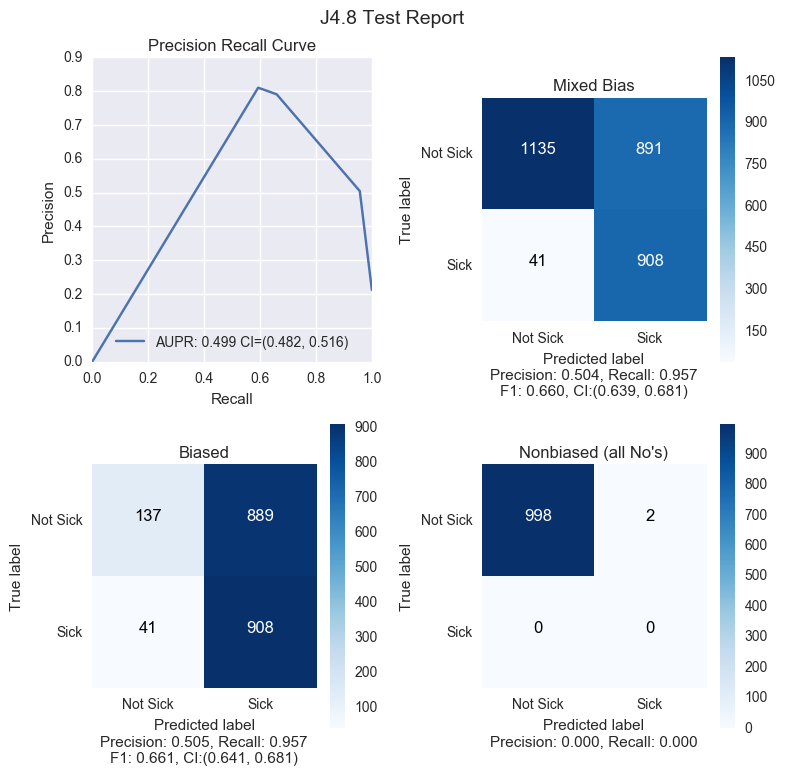

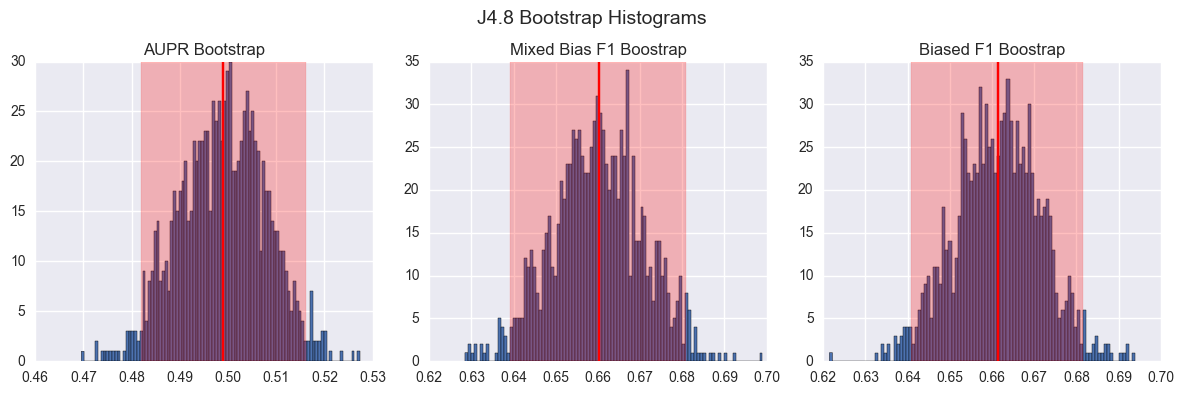

In [236]:
old_sick_results = old_model_report(test_data['is_foodborne'], old_sick_scores, test_data['is_biased'], 'J4.8', B=1000)


B: 999/1000
B: 999/1000
B: 999/1000


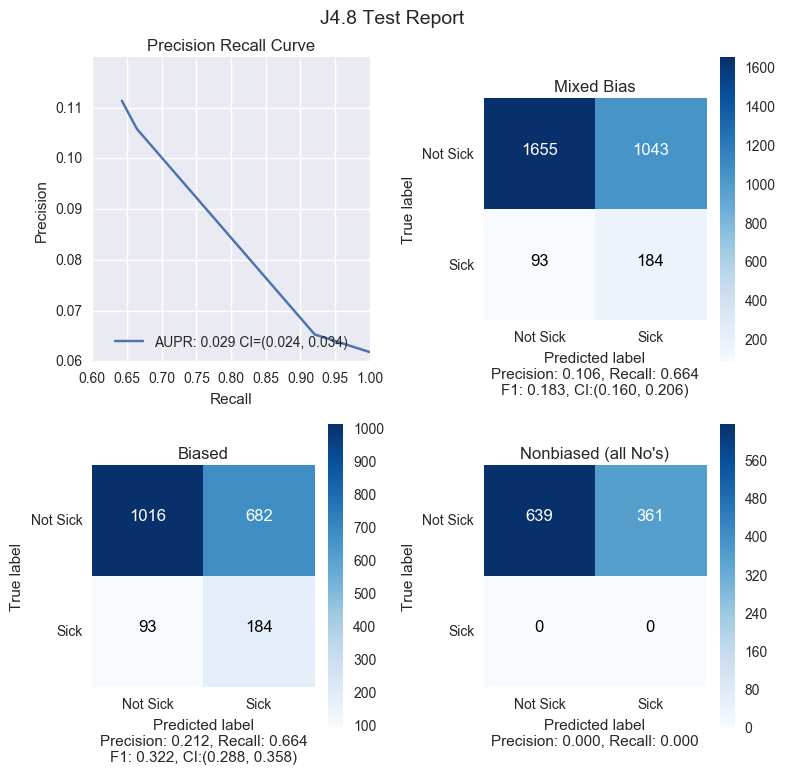

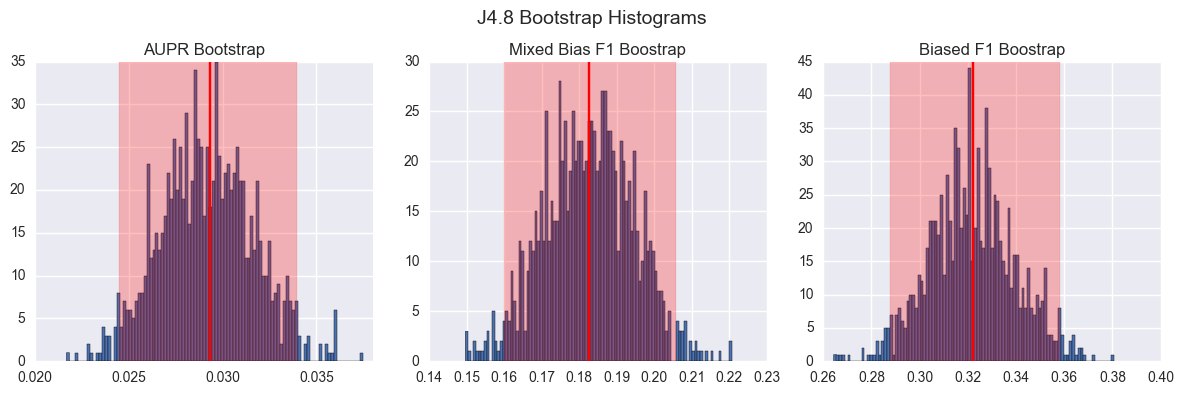

In [238]:
old_mult_results = old_model_report(test_data['is_multiple'], old_mult_scores, test_data['is_biased'], 'J4.8', B=1000)

In [ ]:
joblib.dump(value=)